In [ ]:
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from dateutil import parser as dateutil_parser
import traceback

In [ ]:
"""
ohio_parse_and_merge.py

Parses Ohio-style XML patient files into CSVs and creates a merged CGM-centric dataset
with event features (insulin_last_30min, carbs_last_30min, latest_basal_rate).


Usage:
    python ohio_parse_and_merge.py

Requirements:
    pip install pandas python-dateutil
"""



# -------- USER CONFIGURE ----------
DATA_DIR = Path("/content/drive/MyDrive/glucose_folder")   # folder containing the 12 xml files
OUT_DIR = Path("/content/drive/MyDrive/glucose_csv")           # where CSVs will be saved
IOB_WINDOW_MIN = 30                             # window to sum insulin and carbs (minutes)
OUT_DIR.mkdir(parents=True, exist_ok=True)
# ----------------------------------

def parse_timestamp(txt):
    """Robust timestamp parsing for formats like '18-01-2022 00:01:00' etc.
       Returns pandas.Timestamp or None if blank/invalid."""
    if txt is None or str(txt).strip() == "":
        return None
    txt = txt.strip()
    # try common explicit formats first (fast)
    for fmt in ("%d-%m-%Y %H:%M:%S", "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M:%S"):
        try:
            return pd.Timestamp(datetime.strptime(txt, fmt))
        except Exception:
            pass
    # fallback to dateutil
    try:
        return pd.to_datetime(dateutil_parser.parse(txt, dayfirst=True))
    except Exception:
        # final fallback to pandas (may still fail)
        try:
            return pd.to_datetime(txt)
        except Exception:
            return None

def extract_event_list(root, tag, attr_map):
    """
    Generic extractor for <tag> containing <event .../> nodes.
    attr_map: dict column_name -> xml attribute name (eg {"glucose":"value"})
    Returns list of dicts with 'timestamp' (pd.Timestamp) and columns per attr_map.
    """
    out = []
    node = root.find(tag)
    if node is None:
        # try case-insensitive match
        for child in root:
            if child.tag.lower() == tag.lower():
                node = child
                break
        if node is None:
            return out

    for ev in node.findall(".//event"):
        row = {}
        # choose preferred timestamp attribute priority
        ts_candidates = [ev.attrib.get("ts"), ev.attrib.get("ts_begin"), ev.attrib.get("tbegin"), ev.attrib.get("timestamp"), ev.attrib.get("time")]
        ts_val = None
        for c in ts_candidates:
            if c:
                ts_val = c; break
        # fallback to explicit attributes for some tags
        if ts_val is None:
            ts_val = ev.attrib.get("ts") or ev.attrib.get("ts_begin") or ev.attrib.get("tbegin")
        ts = parse_timestamp(ts_val)
        if ts is None:
            # skip events with no parseable time
            continue
        row["timestamp"] = ts
        # also capture ts_end if present
        ts_end_val = ev.attrib.get("ts_end") or ev.attrib.get("tend") or ev.attrib.get("ts_end")
        row["timestamp_end"] = parse_timestamp(ts_end_val) if ts_end_val else None

        # map attributes
        for col, xml_attr in attr_map.items():
            v = ev.attrib.get(xml_attr)
            # if attribute missing, also try same name lower/upper
            if v is None:
                v = ev.attrib.get(xml_attr.lower()) or ev.attrib.get(xml_attr.upper())
            # attempt numeric conversion where appropriate
            if v is None or v == "":
                row[col] = None
            else:
                # keep as float when possible
                try:
                    row[col] = float(v)
                except Exception:
                    row[col] = v
        # keep raw attrs if needed
        row["_raw"] = str(ev.attrib)
        out.append(row)
    return out

def parse_patient_file(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Failed to parse {xml_path}: {e}")
        return None

    subject_id = root.attrib.get("id") or xml_path.stem.split("-")[0]
    subject_weight = root.attrib.get("weight")
    insulin_type = root.attrib.get("insulin_type")

    # extract channels using attribute names found in your sample XML
    glucose_events = extract_event_list(root, "glucose_level", {"glucose": "value"})
    fingerstick_events = extract_event_list(root, "finger_stick", {"finger_glucose": "value"})
    basal_events = extract_event_list(root, "basal", {"rate": "value"})
    temp_basal_events = extract_event_list(root, "temp_basal", {"rate": "value"})
    bolus_events = extract_event_list(root, "bolus", {"dose": "dose", "type": "type"})  # dose attr present in sample
    meal_events = extract_event_list(root, "meal", {"carbs": "carbs", "meal_type": "type"})
    sleep_events = extract_event_list(root, "sleep", {"quality": "quality"})
    work_events = extract_event_list(root, "work", {"intensity": "intensity"})
    illness_events = extract_event_list(root, "illness", {"description": "description"})
    exercise_events = extract_event_list(root, "exercise", {"intensity": "intensity", "duration": "duration"})
    basis_hr = extract_event_list(root, "basis_heart_rate", {"hr": "value"})
    basis_gsr = extract_event_list(root, "basis_gsr", {"gsr": "value"})
    basis_skin_temp = extract_event_list(root, "basis_skin_temperature", {"skin_temp": "value"})
    basis_air_temp = extract_event_list(root, "basis_air_temperature", {"air_temp": "value"})
    basis_steps = extract_event_list(root, "basis_steps", {"steps": "value"})
    basis_sleep = extract_event_list(root, "basis_sleep", {"quality": "quality"})
    # skip stressors and hypo_event as you asked

    # convert to dataframes (may be empty)
    def to_df(events, cols_map=None):
        if not events:
            return pd.DataFrame()
        df = pd.DataFrame(events)
        # ensure timestamp type
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        if "timestamp_end" in df.columns:
            df["timestamp_end"] = pd.to_datetime(df["timestamp_end"])
        df = df.sort_values("timestamp").reset_index(drop=True)
        # add subject metadata columns
        df["subject_id"] = subject_id
        df["subject_weight"] = subject_weight
        df["insulin_type"] = insulin_type
        return df

    parsed = {
        "subject_id": subject_id,
        "cgm": to_df(glucose_events),
        "finger_stick": to_df(fingerstick_events),
        "basal": to_df(basal_events),
        "temp_basal": to_df(temp_basal_events),
        "bolus": to_df(bolus_events),
        "meal": to_df(meal_events),
        "sleep": to_df(sleep_events),
        "work": to_df(work_events),
        "illness": to_df(illness_events),
        "exercise": to_df(exercise_events),
        "basis_hr": to_df(basis_hr),
        "basis_gsr": to_df(basis_gsr),
        "basis_skin_temp": to_df(basis_skin_temp),
        "basis_air_temp": to_df(basis_air_temp),
        "basis_steps": to_df(basis_steps),
        "basis_sleep": to_df(basis_sleep),
    }
    return parsed

def save_parsed(all_subjects):
    # save per-subject CSVs and combined CSVs
    channels = ["cgm","finger_stick","basal","temp_basal","bolus","meal","sleep","work","illness","exercise",
                "basis_hr","basis_gsr","basis_skin_temp","basis_air_temp","basis_steps","basis_sleep"]
    # per-subject
    for sid, tables in all_subjects.items():
        for ch in channels:
            df = tables.get(ch)
            if df is None or df.empty:
                continue
            out = OUT_DIR / f"{sid}_{ch}.csv"
            df.to_csv(out, index=False)
            print(f"Saved: {out} ({len(df)} rows)")

    # combined
    for ch in channels:
        frames = []
        for sid, tables in all_subjects.items():
            df = tables.get(ch)
            if df is None or df.empty:
                continue
            frames.append(df)
        if frames:
            combined = pd.concat(frames, ignore_index=True).sort_values(["subject_id","timestamp"])
            combined.to_csv(OUT_DIR / f"combined_{ch}.csv", index=False)
            print(f"Saved combined_{ch}.csv ({len(combined)} rows)")

def merge_to_master():
    """Create a CGM-centric master dataset with event features."""
    cgm_path = OUT_DIR / "combined_cgm.csv"
    bolus_path = OUT_DIR / "combined_bolus.csv"
    meal_path = OUT_DIR / "combined_meal.csv"
    basal_path = OUT_DIR / "combined_basal.csv"

    if not cgm_path.exists():
        print("combined_cgm.csv not found. Run parse first.")
        return

    cgm = pd.read_csv(cgm_path, parse_dates=["timestamp"])
    # ensure subject_id exists
    if "subject_id" not in cgm.columns:
        raise ValueError("combined_cgm.csv missing subject_id column")

    # load events if present else create empty
    bolus = pd.read_csv(bolus_path, parse_dates=["timestamp"]) if bolus_path.exists() else pd.DataFrame(columns=["timestamp","dose","subject_id"])
    meal = pd.read_csv(meal_path, parse_dates=["timestamp"]) if meal_path.exists() else pd.DataFrame(columns=["timestamp","carbs","subject_id"])
    basal = pd.read_csv(basal_path, parse_dates=["timestamp"]) if basal_path.exists() else pd.DataFrame(columns=["timestamp","rate","subject_id"])

    # rename ambiguous columns if necessary
    if "dose" not in bolus.columns and "value" in bolus.columns:
        bolus = bolus.rename(columns={"value":"dose"})
    if "carbs" not in meal.columns and "value" in meal.columns:
        meal = meal.rename(columns={"value":"carbs"})
    if "rate" not in basal.columns and "value" in basal.columns:
        basal = basal.rename(columns={"value":"rate"})

    # sort
    cgm = cgm.sort_values(["subject_id","timestamp"]).reset_index(drop=True)
    bolus = bolus.sort_values(["subject_id","timestamp"]).reset_index(drop=True)
    meal = meal.sort_values(["subject_id","timestamp"]).reset_index(drop=True)
    basal = basal.sort_values(["subject_id","timestamp"]).reset_index(drop=True)

    # initialize features
    cgm["insulin_last_30min"] = 0.0
    cgm["carbs_last_30min"] = 0.0
    cgm["latest_basal_rate"] = None

    # process per subject
    subjects = cgm["subject_id"].unique()
    for sid in subjects:
        g = cgm[cgm["subject_id"] == sid]
        b_sub = bolus[bolus["subject_id"] == sid] if not bolus.empty else pd.DataFrame(columns=bolus.columns)
        m_sub = meal[meal["subject_id"] == sid] if not meal.empty else pd.DataFrame(columns=meal.columns)
        basal_sub = basal[basal["subject_id"] == sid] if not basal.empty else pd.DataFrame(columns=basal.columns)

        # make sure timestamps parsed
        b_sub["timestamp"] = pd.to_datetime(b_sub["timestamp"], errors="coerce")
        m_sub["timestamp"] = pd.to_datetime(m_sub["timestamp"], errors="coerce")
        basal_sub["timestamp"] = pd.to_datetime(basal_sub["timestamp"], errors="coerce")

        # iterate (vectorized approach is possible but simple loop is clearer)
        idxs = g.index.tolist()
        for idx in idxs:
            t = g.at[idx, "timestamp"]
            t_pd = pd.to_datetime(t)
            # insulin in past window
            if not b_sub.empty:
                mask_i = (b_sub["timestamp"] <= t_pd) & (b_sub["timestamp"] >= t_pd - pd.Timedelta(minutes=IOB_WINDOW_MIN))
                insulin_sum = b_sub.loc[mask_i, "dose"].fillna(0).sum() if "dose" in b_sub.columns else 0.0
            else:
                insulin_sum = 0.0
            # carbs in past window
            if not m_sub.empty:
                mask_c = (m_sub["timestamp"] <= t_pd) & (m_sub["timestamp"] >= t_pd - pd.Timedelta(minutes=IOB_WINDOW_MIN))
                carbs_sum = m_sub.loc[mask_c, "carbs"].fillna(0).sum() if "carbs" in m_sub.columns else 0.0
            else:
                carbs_sum = 0.0
            # latest basal rate at or before t
            latest_basal = None
            if not basal_sub.empty:
                prior = basal_sub[basal_sub["timestamp"] <= t_pd]
                if not prior.empty:
                    # take the last record's rate
                    latest_basal = prior.iloc[-1].get("rate", None)
            # assign
            cgm.at[idx, "insulin_last_30min"] = float(insulin_sum)
            cgm.at[idx, "carbs_last_30min"] = float(carbs_sum)
            cgm.at[idx, "latest_basal_rate"] = float(latest_basal) if latest_basal is not None else None

    # save master
    master_path = OUT_DIR / "final_merged_glucose_dataset.csv"
    cgm.to_csv(master_path, index=False)
    print(f"Saved master merged dataset: {master_path} ({len(cgm)} rows)")

def main():
    xml_files = sorted(DATA_DIR.glob("*.xml"))
    if not xml_files:
        print("No XML files found in DATA_DIR. Update DATA_DIR and try again.")
        return

    all_subjects = {}
    for xf in xml_files:
        try:
            print("Parsing:", xf.name)
            parsed = parse_patient_file(xf)
            if parsed:
                sid = parsed["subject_id"]
                all_subjects[sid] = parsed
        except Exception as e:
            print(f"Error parsing {xf}: {e}")
            traceback.print_exc()

    if not all_subjects:
        print("No subjects parsed.")
        return

    save_parsed(all_subjects)
    merge_to_master()
    print("Done.")

if __name__ == "__main__":
    main()

Parsing: 559-ws-testing.xml
Parsing: 559-ws-training.xml
Parsing: 563-ws-testing.xml
Parsing: 563-ws-training.xml


KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/glucose_csv/final_merged_glucose_dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69255 entries, 0 to 69254
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           69255 non-null  object 
 1   timestamp_end       0 non-null      float64
 2   glucose             69255 non-null  float64
 3   _raw                69255 non-null  object 
 4   subject_id          69255 non-null  int64  
 5   subject_weight      69255 non-null  int64  
 6   insulin_type        69255 non-null  object 
 7   insulin_last_30min  69255 non-null  float64
 8   carbs_last_30min    69255 non-null  float64
 9   latest_basal_rate   69243 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 5.3+ MB


In [ ]:
df.isna().sum()

,0
timestamp,0
timestamp_end,69255
glucose,0
_raw,0
subject_id,0
subject_weight,0
insulin_type,0
insulin_last_30min,0
carbs_last_30min,0
latest_basal_rate,12


/tmp/ipython-input-3251742742.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['insulin_last_30min'], hist=False);


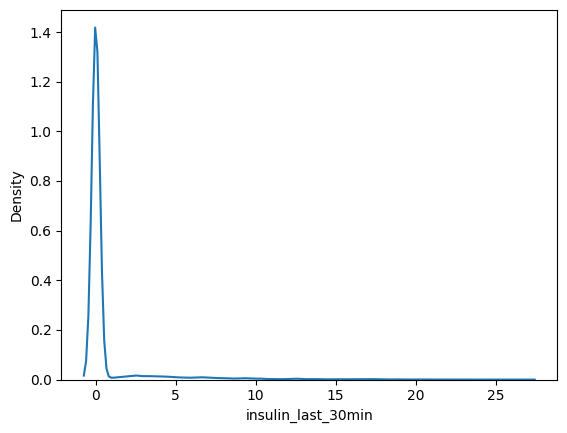

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df['insulin_last_30min'], hist=False);

In [ ]:
df['insulin_last_30min'].value_counts()/df.shape[0]*100

,count
insulin_last_30min,
0.00,89.646957
3.30,0.271461
2.50,0.248358
2.70,0.203595
4.40,0.203595
...,...
10.80,0.001444
15.90,0.001444
11.70,0.001444


In [ ]:
df['carbs_last_30min'].value_counts()/df.shape[0]*100

,count
carbs_last_30min,
0.0,90.984044
15.0,0.886579
30.0,0.672876
45.0,0.544365
40.0,0.499603
...,...
64.0,0.008664
2.0,0.008664
102.0,0.008664


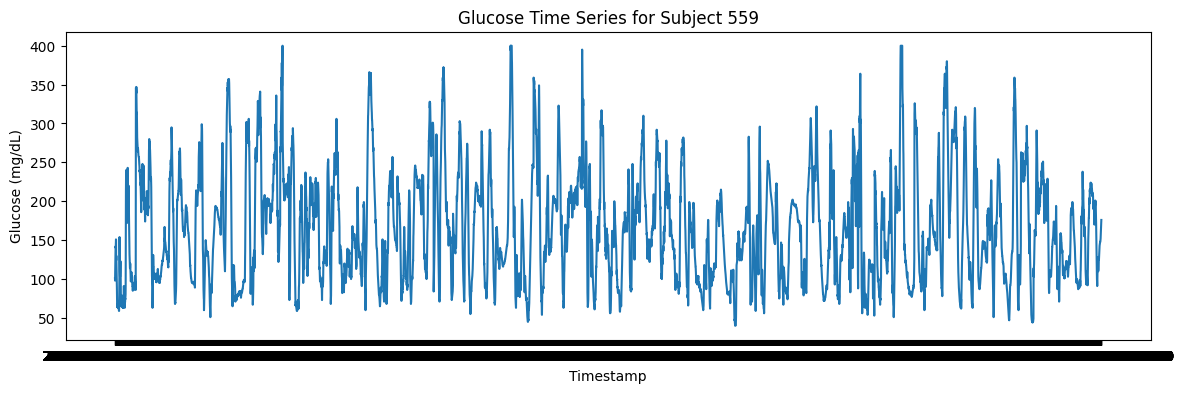

In [ ]:
sample_subject = df['subject_id'].iloc[0]
sub_df = df[df['subject_id'] == sample_subject].copy()

plt.figure(figsize=(14,4))
plt.plot(sub_df['timestamp'], sub_df['glucose'])
plt.title(f"Glucose Time Series for Subject {sample_subject}")
plt.xlabel("Timestamp")
plt.ylabel("Glucose (mg/dL)")
plt.show()


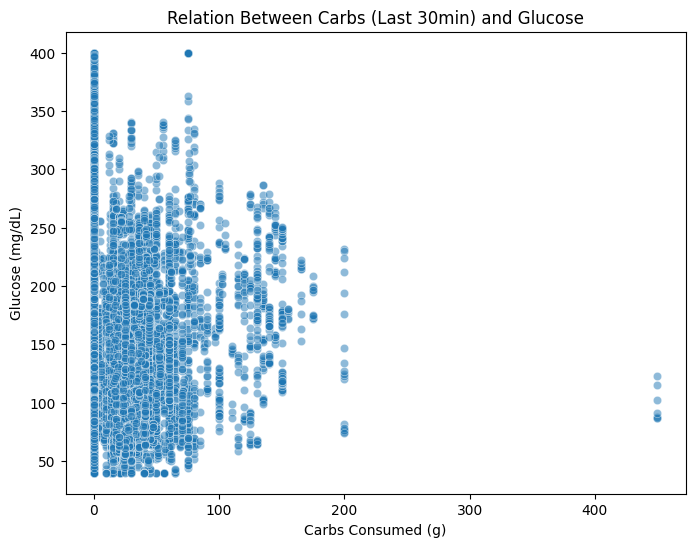

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='carbs_last_30min', y='glucose', data=df, alpha=0.5)
plt.title("Relation Between Carbs (Last 30min) and Glucose")
plt.xlabel("Carbs Consumed (g)")
plt.ylabel("Glucose (mg/dL)")
plt.show()


In [ ]:
df['glucose_delta_5min'] = df.groupby('subject_id')['glucose'].diff().fillna(0)
df['glucose_delta_10min'] = df.groupby('subject_id')['glucose'].diff(2).fillna(0)
df['glucose_slope_30min'] = df.groupby('subject_id')['glucose'].diff(6).fillna(0) / 30  # assuming 5-min interval

In [ ]:
df['carbs_60min'] = df.groupby('subject_id')['carbs_last_30min'].rolling(window=2, min_periods=1).sum().reset_index(0, drop=True)
df['carbs_120min'] = df.groupby('subject_id')['carbs_last_30min'].rolling(window=4, min_periods=1).sum().reset_index(0, drop=True)


In [ ]:
import numpy as np

def compute_iob(series, tau=6):
    """Compute simple exponential decay of insulin activity (tau in 30-min units)."""
    decay = np.exp(-np.arange(len(series))/tau)
    iob = np.zeros_like(series)
    for t in range(len(series)):
        if series[t] > 0:
            iob[t:] += series[t] * decay[:len(series)-t]
    return iob

df['iob_simulated'] = df.groupby('subject_id')['latest_basal_rate'].transform(lambda s: compute_iob(s.values))


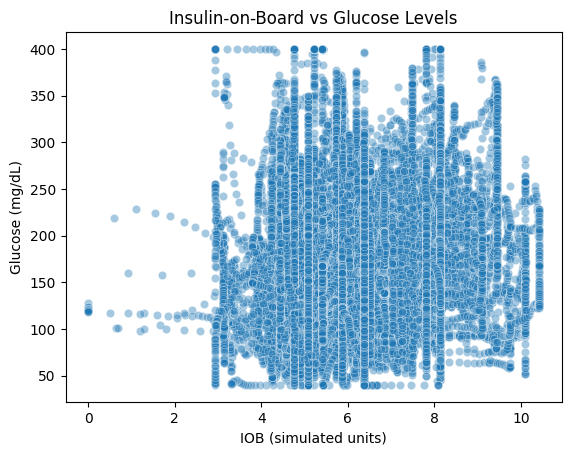

In [ ]:
sns.scatterplot(x='iob_simulated', y='glucose', data=df, alpha=0.4)
plt.title("Insulin-on-Board vs Glucose Levels")
plt.xlabel("IOB (simulated units)")
plt.ylabel("Glucose (mg/dL)")
plt.show()


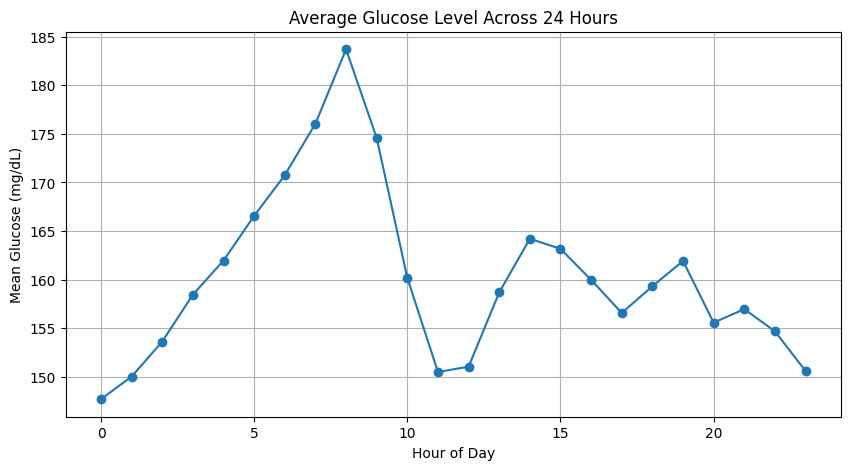

In [ ]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
hourly_mean = df.groupby('hour')['glucose'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.title("Average Glucose Level Across 24 Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Glucose (mg/dL)")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
# Binary column: 1 if carbs_last_30min > 0 else 0
df["meal_flag"] = (df["carbs_last_30min"] > 0).astype(int)

# Optional: Drop the numeric column if you only want the flag
# df = df.drop(columns=["carbs_last_30min"])

# Save

# Binary insulin flag (1 if insulin taken recently)
df["insulin_flag"] = (df["insulin_last_30min"] > 0).astype(int)


In [ ]:
# df_carbs=pd.read_csv("/content/path/to/output_csvs/carbs_last30min_fixed.csv")

In [ ]:
# df_carbs['carbs_last_30min'].value_counts()/df_carbs['carbs_last_30min'].shape[0]*100

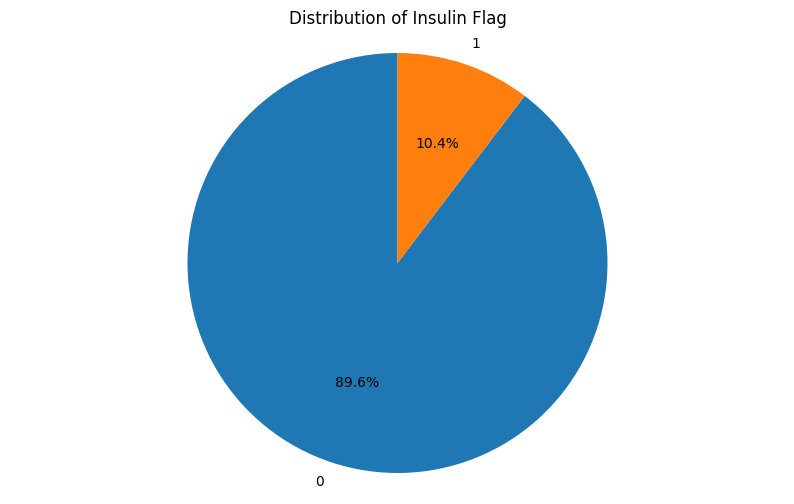

In [ ]:
plt.figure(figsize=(10,6))
# Use plt.pie() from matplotlib instead of sns.piechart()
plt.pie(df['insulin_flag'].value_counts(), labels=df['insulin_flag'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Insulin Flag')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

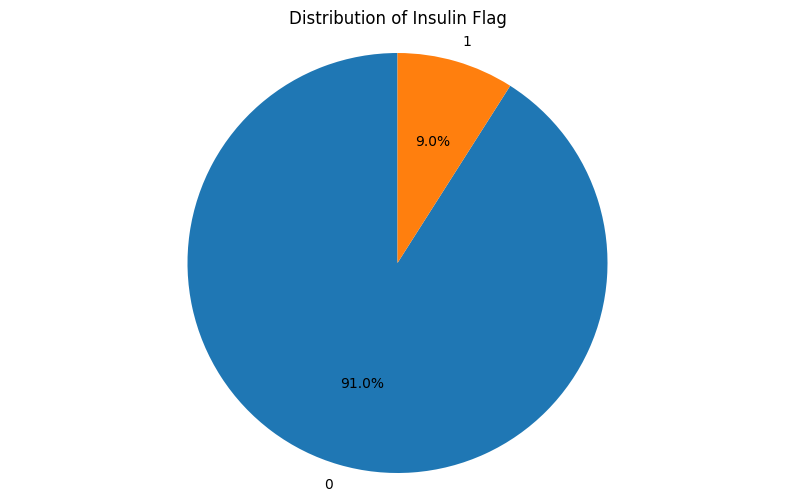

In [ ]:
plt.figure(figsize=(10,6))
# Use plt.pie() from matplotlib instead of sns.piechart()
plt.pie(df['meal_flag'].value_counts(), labels=df['insulin_flag'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Insulin Flag')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
df.drop(columns='timestamp_end', inplace=True)

In [ ]:
df.drop(columns='_raw', inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

,0
timestamp,0
glucose,0
subject_id,0
subject_weight,0
insulin_type,0
insulin_last_30min,0
carbs_last_30min,0
latest_basal_rate,0
glucose_delta_5min,0
glucose_delta_10min,0


In [ ]:
df['glucose_mean_30min'] = df.groupby('subject_id')['glucose'].rolling(window=6, min_periods=1).mean().reset_index(0, drop=True)
df['glucose_std_30min']  = df.groupby('subject_id')['glucose'].rolling(window=6, min_periods=1).std().reset_index(0, drop=True).fillna(0)


In [ ]:

# Sort by subject and time (important)
df = df.sort_values(["subject_id", "timestamp"]).reset_index(drop=True)

# Create a new column: glucose value 6 steps (≈30 mins) ahead within each subject
df["future_glucose_30min"] = (
    df.groupby("subject_id")["glucose"].shift(-6)
)

# Drop any rows where the future glucose is NaN (end of sequence)
df = df.dropna(subset=["future_glucose_30min"]).reset_index(drop=True)

# Save the updated dataset
df.to_csv("glucose_with_future.csv", index=False)

print(df[["timestamp", "glucose", "future_glucose_30min"]].head(10))

             timestamp  glucose  future_glucose_30min
0  2021-12-07 01:17:00    101.0                 135.0
1  2021-12-07 01:22:00     98.0                 142.0
2  2021-12-07 01:27:00    104.0                 140.0
3  2021-12-07 01:32:00    112.0                 145.0
4  2021-12-07 01:37:00    120.0                 148.0
5  2021-12-07 01:42:00    127.0                 151.0
6  2021-12-07 01:47:00    135.0                 150.0
7  2021-12-07 01:52:00    142.0                 124.0
8  2021-12-07 01:57:00    140.0                 130.0
9  2021-12-07 02:02:00    145.0                 127.0


In [ ]:
df['insulin_type'].value_counts(1)*100

,proportion
insulin_type,
Novalog,66.630543
Humalog 200,17.509789
Humalog,15.859667


In [ ]:
df.drop(columns=['insulin_last_30min', 'carbs_last_30min'], inplace=True)

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Extract features
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["day_of_week"] = df["timestamp"].dt.dayofweek

# Optional: use cyclic encoding for time (so 23:59 and 00:00 are close)
import numpy as np
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

In [ ]:
df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe=OneHotEncoder(sparse_output=False)
df_encoded=ohe.fit_transform(df[['insulin_type']])

In [ ]:
encoded_df = pd.DataFrame(df_encoded, columns=ohe.get_feature_names_out(["insulin_type"]))


In [ ]:
df=pd.concat([df, encoded_df], axis=1)

In [ ]:
df.drop(columns='insulin_type', inplace=True)

In [ ]:
# df.drop(columns='timestamp', inplace=True)

In [ ]:
df[['insulin_type_Humalog', 'insulin_type_Humalog 200', 'insulin_type_Novalog']]=df[['insulin_type_Humalog', 'insulin_type_Humalog 200', 'insulin_type_Novalog']].astype(int)

In [ ]:
df.columns

Index(['timestamp', 'glucose', 'subject_id', 'subject_weight',
       'latest_basal_rate', 'glucose_delta_5min', 'glucose_delta_10min',
       'glucose_slope_30min', 'carbs_60min', 'carbs_120min', 'iob_simulated',
       'hour', 'meal_flag', 'insulin_flag', 'glucose_mean_30min',
       'glucose_std_30min', 'future_glucose_30min', 'minute', 'day_of_week',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'insulin_type_Humalog',
       'insulin_type_Humalog 200', 'insulin_type_Novalog'],
      dtype='object')

In [ ]:
df = df.sort_values(['subject_id', 'timestamp']).reset_index(drop=True)

In [ ]:
df.head()

,timestamp,glucose,subject_id,subject_weight,latest_basal_rate,glucose_delta_5min,glucose_delta_10min,glucose_slope_30min,carbs_60min,carbs_120min,...,future_glucose_30min,minute,day_of_week,hour_sin,hour_cos,dow_sin,dow_cos,insulin_type_Humalog,insulin_type_Humalog 200,insulin_type_Novalog
0,2021-12-07 01:17:00,101.0,559,99,0.65,0.0,0.0,0.0,0.0,0.0,...,135.0,17,1,0.258819,0.965926,0.781831,0.62349,0,0,1
1,2021-12-07 01:22:00,98.0,559,99,0.65,-3.0,0.0,0.0,0.0,0.0,...,142.0,22,1,0.258819,0.965926,0.781831,0.62349,0,0,1
2,2021-12-07 01:27:00,104.0,559,99,0.65,6.0,3.0,0.0,0.0,0.0,...,140.0,27,1,0.258819,0.965926,0.781831,0.62349,0,0,1
3,2021-12-07 01:32:00,112.0,559,99,0.65,8.0,14.0,0.0,0.0,0.0,...,145.0,32,1,0.258819,0.965926,0.781831,0.62349,0,0,1
4,2021-12-07 01:37:00,120.0,559,99,0.65,8.0,16.0,0.0,0.0,0.0,...,148.0,37,1,0.258819,0.965926,0.781831,0.62349,0,0,1


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# X=df.drop(columns=['future_glucose_30min', 'subject_id', 'subject_weight'])
# y=df['future_glucose_30min']

# X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# # X


# Sort by timestamp first


# Define temporal splits (e.g., 4 weeks of data)
n = len(df)
split_points = [int(0.25*n), int(0.5*n), int(0.75*n)]
T1, T2, T3, T4 = np.split(df, split_points)

datasets = {
    'T1': T1,
    'T2': T2,
    'T3': T3,
    'T4': T4
}


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
from sklearn.preprocessing import StandardScaler
feature_cols=df.drop(columns=['future_glucose_30min', 'subject_id', 'subject_weight', 'timestamp']).columns
target_col='future_glucose_30min'
# Fit only on early data (training periods)
train_df = pd.concat([T1, T2])   # training data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training subset only
scaler_X.fit(train_df[feature_cols])
scaler_y.fit(train_df[[target_col]])

# Transform all periods using *same scaler*
for k in ['T1', 'T2', 'T3', 'T4']:
    datasets[k][feature_cols] = scaler_X.transform(datasets[k][feature_cols])
    datasets[k][target_col] = scaler_y.transform(datasets[k][[target_col]])


In [ ]:
# scaler_X=StandardScaler()
# scaler_y=StandardScaler()
# features_to_scale=['glucose', 'glucose_delta_5min', 'glucose_delta_10min',
#        'glucose_slope_30min', 'carbs_60min', 'carbs_120min', 'iob_simulated', 'glucose_mean_30min',
#        'glucose_std_30min', 'hour', 'minute', 'day_of_week', 'hour_sin',
#        'hour_cos', 'dow_sin', 'dow_cos']
# X_train[features_to_scale]=scaler_X.fit_transform(X_train[features_to_scale])
# X_test[features_to_scale]=scaler_X.transform(X_test[features_to_scale])
# y_train_scaled=scaler_y.fit_transform(y_train.values.reshape(-1,1))
# y_test_scaled=scaler_y.transform(y_test.values.reshape(-1,1))

In [ ]:
# X_train.loc[:, :'insulin_flag']

In [ ]:
# X_train.loc[:, 'insulin_flag':]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback - 1, len(X)):
        Xs.append(X[i - lookback + 1 : i + 1])
        ys.append(y[i])  # Include the corresponding y value for the last timestep in the sequence
    return np.array(Xs), np.array(ys)

In [ ]:
def grouped_sequences(df, feature_cols, target_col, lookback):
    X_list, y_list = [], []
    for sid, grp in df.groupby('subject_id', sort=True):
        grp = grp.sort_values('timestamp').reset_index(drop=True)
        Xvals = grp[feature_cols].values
        yvals = grp[target_col].values
        if len(grp) < lookback:
            continue
        Xs, ys = make_sequences(Xvals, yvals, lookback)
        X_list.append(Xs); y_list.append(ys)
    if not X_list:
        return np.empty((0, lookback, len(feature_cols))), np.empty((0,))
    return np.vstack(X_list), np.hstack(y_list)


In [ ]:
LOOKBACK = 12
train_df=pd.concat([datasets['T1'], datasets['T2']])
test_df=datasets['T3']


def build_sequences_for_split(df_chunk):
    X_seq, y_seq = grouped_sequences(df_chunk, feature_cols, target_col, LOOKBACK)
    print(f"{len(X_seq)} sequences built from {len(df_chunk)} rows")
    return X_seq, y_seq

X_T1, y_T1 = build_sequences_for_split(T1)
X_T2, y_T2 = build_sequences_for_split(T2)
X_T3, y_T3 = build_sequences_for_split(T3)
X_T4, y_T4 = build_sequences_for_split(T4)

17279 sequences built from 17301 rows
17269 sequences built from 17302 rows
17280 sequences built from 17302 rows
17280 sequences built from 17302 rows


In [ ]:
# Train on T1+T2, validate on T3, test on T4
X_train_seq = np.concatenate([X_T1, X_T2])
y_train_seq = np.concatenate([y_T1, y_T2])
X_val_seq, y_val_seq = X_T3, y_T3
X_test_seq, y_test_seq = X_T4, y_T4


In [ ]:
y_train_seq

array([-0.79775617, -0.86081359, -0.8923423 , ..., -0.04106714,
        0.05351899,  0.10081205])

In [ ]:
# from keras.layers import LSTM, SpatialDropout1D
# from keras.layers import Input
# from sklearn.metrics import r2_score
# timesteps = X_train_seq.shape[1]; n_features = X_train_seq.shape[2]
# model = Sequential()
# model.add(Input(shape=(timesteps, n_features)))
# model.add(SpatialDropout1D(0.1))
# model.add(LSTM(128, dropout=0.15, recurrent_dropout=0.15))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='linear'))
# model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
#     ModelCheckpoint("best_lstm_scaled_df.h5", monitor='val_loss', save_best_only=True)
# ]

# # split_index = int(0.9 * len(X_train_seq))
# # X_train_final = X_train_seq[:split_index]
# # y_train_final = y_train_seq[:split_index]
# # X_val_final = X_train_seq[split_index:]
# # y_val_final = y_train_seq[split_index:]

# history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=80, batch_size=64, callbacks=callbacks, verbose=2)

# # y_pred_scaled = model.predict(X_val_seq).reshape(-1, 1)
# # y_pred=scaler_y.inverse_transform(y_pred_scaled).squeeze()
# # y_true=scaler_y.inverse_transform(y_val_seq.reshape(-1, 1)).squeeze()
# # print("MAE:", mean_absolute_error(y_true, y_pred), "RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)), "R2 Score :", r2_score(y_true, y_pred))

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

model = Sequential([
    Input(shape=(timesteps, n_features)),
    SpatialDropout1D(0.1),
    LSTM(128, dropout=0.15, recurrent_dropout=0.15),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mae', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint("best_temporal_lstm.h5", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=80, batch_size=64,
    callbacks=callbacks, verbose=2
)


Epoch 1/80


540/540 - 30s - 55ms/step - loss: 0.3542 - mae: 0.3542 - val_loss: 0.3094 - val_mae: 0.3094 - learning_rate: 1.0000e-03
Epoch 2/80


540/540 - 24s - 44ms/step - loss: 0.3000 - mae: 0.3000 - val_loss: 0.3022 - val_mae: 0.3022 - learning_rate: 1.0000e-03
Epoch 3/80


540/540 - 42s - 77ms/step - loss: 0.2842 - mae: 0.2842 - val_loss: 0.2955 - val_mae: 0.2955 - learning_rate: 1.0000e-03
Epoch 4/80
540/540 - 23s - 43ms/step - loss: 0.2761 - mae: 0.2761 - val_loss: 0.3014 - val_mae: 0.3014 - learning_rate: 1.0000e-03
Epoch 5/80


540/540 - 23s - 43ms/step - loss: 0.2688 - mae: 0.2688 - val_loss: 0.2794 - val_mae: 0.2794 - learning_rate: 1.0000e-03
Epoch 6/80
540/540 - 24s - 45ms/step - loss: 0.2661 - mae: 0.2661 - val_loss: 0.2840 - val_mae: 0.2840 - learning_rate: 1.0000e-03
Epoch 7/80
540/540 - 24s - 45ms/step - loss: 0.2637 - mae: 0.2637 - val_loss: 0.2890 - val_mae: 0.2890 - learning_rate: 1.0000e-03
Epoch 8/80
540/540 - 23s - 43ms/step - loss: 0.2594 - mae: 0.2594 - val_loss: 0.2968 - val_mae: 0.2968 - learning_rate: 1.0000e-03
Epoch 9/80
540/540 - 23s - 43ms/step - loss: 0.2584 - mae: 0.2584 - val_loss: 0.2816 - val_mae: 0.2816 - learning_rate: 1.0000e-03
Epoch 10/80
540/540 - 24s - 44ms/step - loss: 0.2525 - mae: 0.2525 - val_loss: 0.2859 - val_mae: 0.2859 - learning_rate: 5.0000e-04
Epoch 11/80
540/540 - 41s - 76ms/step - loss: 0.2504 - mae: 0.2504 - val_loss: 0.2999 - val_mae: 0.2999 - learning_rate: 5.0000e-04
Epoch 12/80


540/540 - 40s - 75ms/step - loss: 0.2484 - mae: 0.2484 - val_loss: 0.2766 - val_mae: 0.2766 - learning_rate: 5.0000e-04
Epoch 13/80
540/540 - 24s - 45ms/step - loss: 0.2466 - mae: 0.2466 - val_loss: 0.2914 - val_mae: 0.2914 - learning_rate: 5.0000e-04
Epoch 14/80
540/540 - 24s - 45ms/step - loss: 0.2467 - mae: 0.2467 - val_loss: 0.3014 - val_mae: 0.3014 - learning_rate: 5.0000e-04
Epoch 15/80
540/540 - 24s - 45ms/step - loss: 0.2468 - mae: 0.2468 - val_loss: 0.2975 - val_mae: 0.2975 - learning_rate: 5.0000e-04
Epoch 16/80
540/540 - 24s - 44ms/step - loss: 0.2456 - mae: 0.2456 - val_loss: 0.2818 - val_mae: 0.2818 - learning_rate: 5.0000e-04
Epoch 17/80
540/540 - 23s - 43ms/step - loss: 0.2431 - mae: 0.2431 - val_loss: 0.2923 - val_mae: 0.2923 - learning_rate: 2.5000e-04
Epoch 18/80
540/540 - 42s - 77ms/step - loss: 0.2416 - mae: 0.2416 - val_loss: 0.3001 - val_mae: 0.3001 - learning_rate: 2.5000e-04
Epoch 19/80
540/540 - 23s - 43ms/step - loss: 0.2418 - mae: 0.2418 - val_loss: 0.2926 - 

In [ ]:
X_train_seq.shape

(34548, 12, 22)

In [ ]:
def evaluate_on_segment(X, y, label):
    y_pred_scaled = model.predict(X).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).squeeze()
    y_true = scaler_y.inverse_transform(y.reshape(-1, 1)).squeeze()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} | MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
    return mae, rmse, r2

metrics = {}
for name, (Xseg, yseg) in zip(['T1','T2','T3','T4'], [(X_T1,y_T1),(X_T2,y_T2),(X_T3,y_T3),(X_T4,y_T4)]):
    metrics[name] = evaluate_on_segment(Xseg, yseg, name)


540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
T1 | MAE=16.912, RMSE=24.041, R²=0.855
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
T2 | MAE=15.554, RMSE=20.717, R²=0.890
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
T3 | MAE=17.543, RMSE=24.856, R²=0.810
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
T4 | MAE=18.483, RMSE=25.575, R²=0.790


In [ ]:
# ===== MC Dropout Uncertainty (run AFTER training) =====
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# How many stochastic forward passes
T_SAMPLES = 50
CONF_Z = 1.96  # ~95% interval

# scaler_y from your pipeline is used to inverse-transform
y_scale = float(scaler_y.scale_[0])
y_mean  = float(scaler_y.mean_[0])

def mc_predict(model, X, T=T_SAMPLES, batch_size=1024):
    """
    Returns mean/std in BOTH scaled and unscaled spaces.
    """
    preds_scaled = []
    for _ in range(T):
        # training=True keeps dropout ON
        y_scaled = model(X, training=True).numpy().reshape(-1)
        preds_scaled.append(y_scaled)
    preds_scaled = np.stack(preds_scaled, axis=0)           # (T, N)
    mu_scaled = preds_scaled.mean(axis=0)                   # (N,)
    sd_scaled = preds_scaled.std(axis=0, ddof=1)            # (N,)

    # inverse-transform to original mg/dL
    mu = mu_scaled * y_scale + y_mean
    sd = sd_scaled * y_scale
    return mu_scaled, sd_scaled, mu, sd

def interval_metrics(y_true, mu, sd, z=CONF_Z):
    """
    y_true, mu in original space; sd in original space.
    Returns coverage (PICP) and mean interval width (MPIW).
    """
    lower = mu - z*sd
    upper = mu + z*sd
    covered = (y_true >= lower) & (y_true <= upper)
    picp = covered.mean()                    # coverage %
    mpiw = np.mean(upper - lower)            # average width
    return picp, mpiw, lower, upper

def eval_split_mc(name, X, y_scaled):
    # y_true in original space
    y_true = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).reshape(-1)

    mu_s, sd_s, mu, sd = mc_predict(model, X)
    mae = mean_absolute_error(y_true, mu)
    rmse = np.sqrt(mean_squared_error(y_true, mu))
    picp, mpiw, lower, upper = interval_metrics(y_true, mu, sd, z=CONF_Z)

    # Uncertainty–error correlation (should be positive)
    abs_err = np.abs(y_true - mu)
    corr = np.corrcoef(sd, abs_err)[0,1]

    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, "
          f"PICP@95={picp*100:.1f}%, MPIW={mpiw:.2f}, "
          f"corr(|err|, sd)={corr:.3f}")
    return {
        "name": name, "MAE": mae, "RMSE": rmse,
        "PICP_95": picp, "MPIW": mpiw, "corr_err_sd": corr
    }

mc_results = []
for name, (Xseg, yseg) in zip(['T1','T2','T3','T4'], [(X_T1,y_T1),(X_T2,y_T2),(X_T3,y_T3),(X_T4,y_T4)]):
    if Xseg.shape[0] == 0:
        print(f"{name}: no sequences; skipping.")
        continue
    mc_results.append(eval_split_mc(name, Xseg, yseg))


T1: MAE=14.47, RMSE=22.46, PICP@95=76.4%, MPIW=43.00, corr(|err|, sd)=0.200
T2: MAE=11.52, RMSE=16.95, PICP@95=81.3%, MPIW=41.42, corr(|err|, sd)=0.154
T3: MAE=15.45, RMSE=23.54, PICP@95=74.3%, MPIW=42.50, corr(|err|, sd)=0.228
T4: MAE=16.83, RMSE=24.65, PICP@95=69.8%, MPIW=42.07, corr(|err|, sd)=0.167


In [ ]:
# ===== SHAP for 3D LSTM inputs (run AFTER training the LSTM) =====
import os
import numpy as np
import shap

# --- config ---
BACKGROUND_SAMPLES = 200
EXPLAIN_SAMPLES = 500
SAVE_DIR = "shap_temporal_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- background set from training sequences ---
X_bg_pool = X_train_seq
bg_n = min(BACKGROUND_SAMPLES, X_bg_pool.shape[0])
background = X_bg_pool[np.random.choice(X_bg_pool.shape[0], size=bg_n, replace=False)]
print("Background shape:", background.shape)  # expect: (bg_n, timesteps, n_features)

# --- ensure the model is "built" so Keras defines input/output tensors ---
_ = model.predict(background[:1], verbose=0)
inputs = model.inputs if hasattr(model, "inputs") else [model.input]
outputs = model.outputs if hasattr(model, "outputs") else [model.output]
if isinstance(inputs, (list, tuple)) and len(inputs) == 1:
    inputs = inputs[0]
if isinstance(outputs, (list, tuple)) and len(outputs) == 1:
    outputs = outputs[0]

# --- initialize explainer with (inputs, outputs) to preserve 3D structure ---
explainer = shap.GradientExplainer((inputs, outputs), background)
print("SHAP explainer initialized.")

# --- helpers for aggregations ---
def _to_3d_shap(arr: np.ndarray) -> np.ndarray:
    """
    Coerce SHAP output to (samples, timesteps, features).
    Accepts (N,T,F,1) or (N,T,F); squeezes the last dim if needed.
    """
    a = np.array(arr)
    if a.ndim == 4:
        if a.shape[-1] < 1:
            raise ValueError(f"Unexpected SHAP shape with zero outputs: {a.shape}")
        a = a[..., 0]  # take the single output
    if a.ndim != 3:
        raise ValueError(f"Expected SHAP ndim=3 after squeeze, got {a.shape}")
    return a

def summarize_shap_3d(shap_any: np.ndarray):
    """
    shap_any: SHAP attributions with shape (N,T,F,1) or (N,T,F)
    returns:
      feat_scores: (F,) mean |SHAP| over samples & timesteps
      time_scores: (T,) mean |SHAP| over samples & features
    """
    shap_3d = _to_3d_shap(shap_any)               # (N, T, F)
    mean_abs = np.mean(np.abs(shap_3d), axis=0)   # (T, F)
    feat_scores = np.mean(mean_abs, axis=0)       # (F,)
    time_scores = np.mean(mean_abs, axis=1)       # (T,)
    return feat_scores, time_scores

# --- compute SHAP for each temporal split ---
temporal_shap_results = {}       # per-split per-feature scores
temporal_time_importance = {}    # per-split per-timestep scores

split_names = ['T1', 'T2', 'T3', 'T4']
split_arrays = [X_T1, X_T2, X_T3, X_T4]

for period_name, X_period in zip(split_names, split_arrays):
    if X_period.shape[0] == 0:
        print(f"{period_name}: no sequences; skipping.")
        continue

    m = min(EXPLAIN_SAMPLES, X_period.shape[0])
    X_explain = X_period[:m]

    # compute attributions
    shap_values = explainer.shap_values(X_explain)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    print(f"{period_name} SHAP values raw shape:", np.array(shap_values).shape)  # e.g., (m, T, F, 1) or (m, T, F)

    feat_scores, time_scores = summarize_shap_3d(shap_values)
    temporal_shap_results[period_name] = feat_scores
    temporal_time_importance[period_name] = time_scores

# --- inspect top features on validation split (T3) ---
feat_names = list(feature_cols)
if 'T3' in temporal_shap_results and len(temporal_shap_results['T3']) == len(feat_names):
    feat_importances_T3 = dict(zip(feat_names, temporal_shap_results['T3']))
    topk = sorted(feat_importances_T3.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop-10 features by |SHAP| (T3):")
    for k, v in topk:
        print(f"{k}: {v:.6f}")

# --- optionally: save per-feature and per-timestep importances to CSV ---
try:
    import pandas as pd

    for period_name in split_names:
        if period_name in temporal_shap_results:
            pd.DataFrame({
                "feature": feat_names,
                "mean_abs_shap": temporal_shap_results[period_name]
            }).to_csv(os.path.join(SAVE_DIR, f"feature_importance_{period_name}.csv"), index=False)

        if period_name in temporal_time_importance:
            pd.DataFrame({
                "timestep": np.arange(len(temporal_time_importance[period_name])),
                "mean_abs_shap": temporal_time_importance[period_name]
            }).to_csv(os.path.join(SAVE_DIR, f"time_importance_{period_name}.csv"), index=False)

    print(f"\nSaved SHAP summaries to: {SAVE_DIR}")
except Exception as e:
    print(f"Skipping CSV save (pandas not available or other issue): {e}")


Background shape: (200, 12, 22)
SHAP explainer initialized.


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(500, 12, 22))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(50, 12, 22))']
  warnings.warn(msg)


T1 SHAP values raw shape: (500, 12, 22, 1)
T2 SHAP values raw shape: (500, 12, 22, 1)
T3 SHAP values raw shape: (500, 12, 22, 1)
T4 SHAP values raw shape: (500, 12, 22, 1)

Top-10 features by |SHAP| (T3):
glucose: 0.046477
glucose_mean_30min: 0.021089
glucose_delta_5min: 0.011176
glucose_delta_10min: 0.009066
glucose_slope_30min: 0.006818
glucose_std_30min: 0.004367
insulin_flag: 0.004076
insulin_type_Novalog: 0.002054
meal_flag: 0.002023
carbs_60min: 0.001569

Saved SHAP summaries to: shap_temporal_results


In [ ]:
temporal_shap_results['T2']

array([0.03750675, 0.00068215, 0.0086138 , 0.00683276, 0.00460345,
       0.000533  , 0.00040432, 0.0002872 , 0.00059459, 0.00107808,
       0.0028032 , 0.01844545, 0.00255834, 0.00074916, 0.00059034,
       0.00055491, 0.00100277, 0.00092782, 0.00047339, 0.00081614,
       0.00138582, 0.00093465])

In [ ]:
import pandas as pd

feature_names = list(feature_cols)

df_shap_trends = pd.DataFrame({
    "feature": feature_names,
    "T1": temporal_shap_results["T1"],
    "T2": temporal_shap_results["T2"],
    "T3": temporal_shap_results["T3"],
    "T4": temporal_shap_results["T4"],
})

df_shap_trends["direction_T1_to_T4"] = df_shap_trends["T4"] - df_shap_trends["T1"]
df_shap_trends["trend"] = df_shap_trends["direction_T1_to_T4"].apply(
    lambda x: "increasing" if x>0 else "decreasing"
)

df_shap_trends.sort_values("direction_T1_to_T4", ascending=False).head(15)


,feature,T1,T2,T3,T4,direction_T1_to_T4,trend
2,glucose_delta_5min,0.010485,0.008614,0.011176,0.012658,0.002173,increasing
3,glucose_delta_10min,0.008013,0.006833,0.009066,0.009421,0.001408,increasing
4,glucose_slope_30min,0.005347,0.004603,0.006818,0.006321,0.000973,increasing
1,latest_basal_rate,0.000983,0.000682,0.001398,0.001905,0.000921,increasing
10,insulin_flag,0.002789,0.002803,0.004076,0.003482,0.000693,increasing
7,iob_simulated,0.000609,0.000287,0.000686,0.001060,0.000451,increasing
8,hour,0.000649,0.000595,0.000833,0.000763,0.000114,increasing
6,carbs_120min,0.000760,0.000404,0.001006,0.000868,0.000108,increasing
5,carbs_60min,0.001234,0.000533,0.001569,0.001314,0.000080,increasing
20,insulin_type_Humalog 200,0.000907,0.001386,0.000890,0.000952,0.000046,increasing


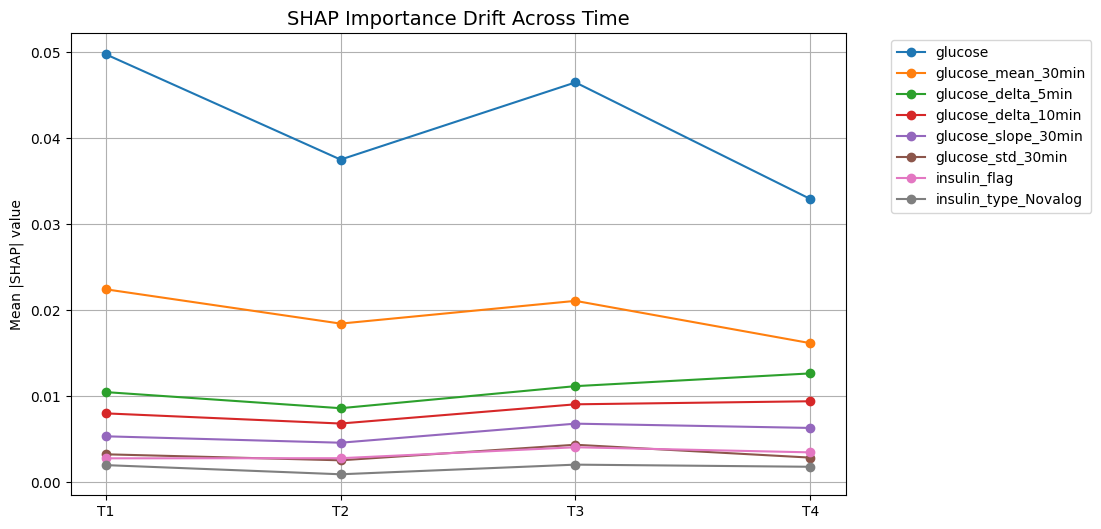

In [ ]:
import matplotlib.pyplot as plt

top_features = df_shap_trends.nlargest(8, "T3")["feature"]

plt.figure(figsize=(10,6))
for f in top_features:
    plt.plot(["T1","T2","T3","T4"], df_shap_trends.set_index("feature").loc[f][["T1","T2","T3","T4"]],
             marker="o")

plt.title("SHAP Importance Drift Across Time", fontsize=14)
plt.ylabel("Mean |SHAP| value")
plt.legend(top_features, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
import shap
import numpy as np
import os

# configuration
BACKGROUND_SAMPLES = 200
EXPLAIN_SAMPLES = 500
SAVE_DIR = "shap_temporal_results"
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
# Use training sequences as background
X_bg_pool = X_train_seq

# Pick a small random subset
bg_n = min(BACKGROUND_SAMPLES, X_bg_pool.shape[0])
background = X_bg_pool[np.random.choice(X_bg_pool.shape[0], size=bg_n, replace=False)]

print("Background shape:", background.shape)


Background shape: (200, 12, 22)


In [ ]:
# Make sure the model is loaded and built
_ = model(background[:1])  # build model if not yet built

# Initialize the explainer
explainer = shap.GradientExplainer(model, background)

print("SHAP explainer initialized successfully.")


SHAP explainer initialized successfully.


In [ ]:
temporal_shap_results = {}
BACKGROUND_SAMPLES = 200     # background reference samples
EXPLAIN_SAMPLES = 500
for period_name, X_period in zip(['T1','T2','T3','T4'], [X_T1, X_T2, X_T3, X_T4]):
    m = min(EXPLAIN_SAMPLES, X_period.shape[0])
    X_explain = X_period[:m]
    shap_values = explainer.shap_values(X_explain)[0]
    mean_abs_shap_feature = np.mean(np.mean(np.abs(shap_values), axis=0), axis=0)
    temporal_shap_results[period_name] = mean_abs_shap_feature


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(500, 12, 22))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 12, 22))']
  warnings.warn(msg)


In [ ]:
print(shap_values.shape)


(12, 22, 1)


In [ ]:
temporal_shap_results

{'T1': array([0.00469468]),
 'T2': array([0.00247639]),
 'T3': array([0.00327653]),
 'T4': array([0.00444717])}

In [ ]:
print("Shape of X_train_seq:", X_train_seq.shape)
print("Feature count (F):", X_train_seq.shape[2])


Shape of X_train_seq: (34548, 12, 22)
Feature count (F): 22


In [ ]:
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine

def shap_consistency(shap_dict):
    periods = list(shap_dict.keys())
    results = []
    for i in range(len(periods) - 1):
        p1, p2 = periods[i], periods[i+1]
        a, b = shap_dict[p1], shap_dict[p2]
        rho, _ = spearmanr(a, b)
        cos_sim = 1 - cosine(a, b)
        results.append((p1, p2, rho, cos_sim))
    return results

consistency_results = shap_consistency(temporal_shap_results)

print("Explainability consistency across temporal segments:")
for p1, p2, rho, cos_sim in consistency_results:
    print(f"{p1} → {p2}: Spearman={rho:.4f}, Cosine={cos_sim:.4f}")


Explainability consistency across temporal segments:
T1 → T2: Spearman=nan, Cosine=1.0000
T2 → T3: Spearman=nan, Cosine=1.0000
T3 → T4: Spearman=nan, Cosine=1.0000


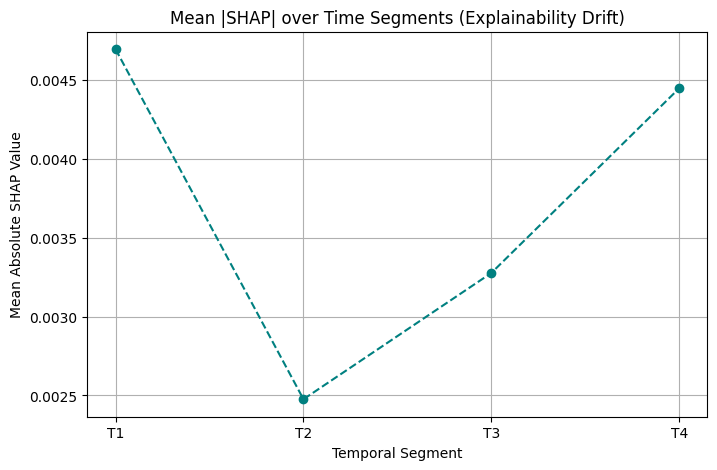

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

periods = list(temporal_shap_results.keys())
mean_values = [np.mean(v) for v in temporal_shap_results.values()]

plt.figure(figsize=(8,5))
plt.plot(periods, mean_values, marker='o', linestyle='--', color='teal')
plt.title("Mean |SHAP| over Time Segments (Explainability Drift)")
plt.xlabel("Temporal Segment")
plt.ylabel("Mean Absolute SHAP Value")
plt.grid(True)
plt.show()


In [ ]:
temporal_shap_results

{'T1': array([0.00469468]),
 'T2': array([0.00247639]),
 'T3': array([0.00327653]),
 'T4': array([0.00444717])}

In [ ]:
y_train_seq.shape

(55354, 1)

In [ ]:
y_val_final.shape

(5536, 1)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_seq)

# Convert from scaled to original (if you scaled y)
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mae = np.mean(np.abs(y_test_seq - y_pred))
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
MAE: 0.2459
RMSE: 0.3788
R² Score: 0.8561


In [ ]:
# if y_scaler is sklearn StandardScaler fitted on y_train
preds_scaled = preds.squeeze()        # predicted values from model (scaled)
y_test_scaled_seq = y_test_seq        # your test target (scaled)

# Inverse scale
try:
    preds_unscaled = y_scaler.inverse_transform(preds_scaled.reshape(-1,1)).squeeze()
    y_test_unscaled = y_scaler.inverse_transform(y_test_scaled_seq.reshape(-1,1)).squeeze()
    print("Inverse transform successful — metrics will be in mg/dL below.")
except NameError:
    print("y_scaler not found. If your y was scaled, assign the scaler to variable `y_scaler` and re-run.")
    preds_unscaled = preds_scaled
    y_test_unscaled = y_test_scaled_seq


y_scaler not found. If your y was scaled, assign the scaler to variable `y_scaler` and re-run.


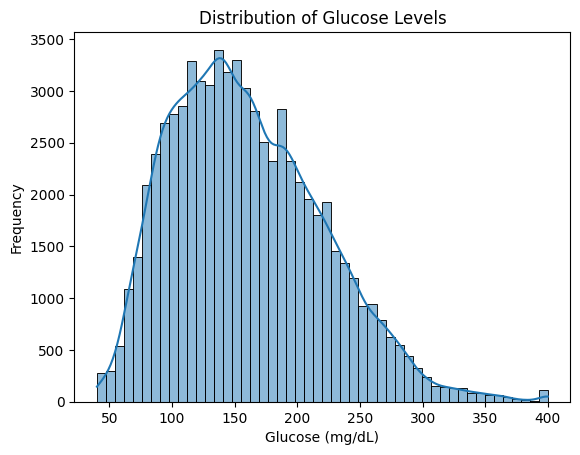

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['glucose'], bins=50, kde=True)
plt.title("Distribution of Glucose Levels")
plt.xlabel("Glucose (mg/dL)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df.head()

,glucose,subject_id,subject_weight,latest_basal_rate,glucose_delta_5min,glucose_delta_10min,glucose_slope_30min,carbs_60min,carbs_120min,iob_simulated,...,hour,minute,day_of_week,hour_sin,hour_cos,dow_sin,dow_cos,insulin_type_Humalog,insulin_type_Humalog 200,insulin_type_Novalog
0,101.0,559,99,0.65,0.0,0.0,0.0,0.0,0.0,0.650000,...,1,17,1,0.258819,0.965926,0.781831,0.62349,0,0,1
1,98.0,559,99,0.65,-3.0,0.0,0.0,0.0,0.0,1.200213,...,1,22,1,0.258819,0.965926,0.781831,0.62349,0,0,1
2,104.0,559,99,0.65,6.0,3.0,0.0,0.0,0.0,1.665958,...,1,27,1,0.258819,0.965926,0.781831,0.62349,0,0,1
3,112.0,559,99,0.65,8.0,14.0,0.0,0.0,0.0,2.060203,...,1,32,1,0.258819,0.965926,0.781831,0.62349,0,0,1
4,120.0,559,99,0.65,8.0,16.0,0.0,0.0,0.0,2.393925,...,1,37,1,0.258819,0.965926,0.781831,0.62349,0,0,1


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='carbs_last_30min', y='glucose', data=df, alpha=0.5)
plt.title("Relation Between Carbs (Last 30min) and Glucose")
plt.xlabel("Carbs Consumed (g)")
plt.ylabel("Glucose (mg/dL)")
plt.show()


ValueError: Could not interpret value `carbs_last_30min` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
model =models.Sequential()

# --- Convolutional layers for local feature extraction ---
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))  # helps prevent overfitting

# --- LSTM layer for temporal dependencies ---
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.2))

# --- Fully connected layers ---
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))  # final output (predicted future glucose)

# --- Compile the model ---
optimizer = optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# --- Summary ---
model.summary()
split_index = int(0.9 * len(X_train_seq))
X_train_final = X_train_seq[:split_index]
y_train_final = y_train_seq[:split_index]
X_val_final = X_train_seq[split_index:]
y_val_final = y_train_seq[split_index:]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint("best_conv1d_lstm.h5", monitor='val_loss', save_best_only=True)
]

# --- Train the model ---
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=60,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=callbacks
)
y_pred_scaled=model.predict(X_test_seq).reshape(-1, 1)
y_pred=scaler_y.inverse_transform(y_pred_scaled).squeeze()
y_true=scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).squeeze()
# --- Evaluate ---
# test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq)
# print(f"\nTest MAE (scaled units): {test_mae:.4f}")

print("MAE:", mean_absolute_error(y_true, y_pred), "RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)), "R2 Score :", r2_score(y_true, y_pred))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 12, 64)         │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,665 (662.75 KB)

 Trainable params: 169,281 (661.25 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/60


779/779 - 37s - 47ms/step - loss: 0.3273 - mae: 0.3273 - val_loss: 0.2757 - val_mae: 0.2757 - learning_rate: 1.0000e-03
Epoch 2/60


779/779 - 31s - 40ms/step - loss: 0.2759 - mae: 0.2759 - val_loss: 0.2626 - val_mae: 0.2626 - learning_rate: 1.0000e-03
Epoch 3/60


779/779 - 31s - 40ms/step - loss: 0.2675 - mae: 0.2675 - val_loss: 0.2558 - val_mae: 0.2558 - learning_rate: 1.0000e-03
Epoch 4/60


779/779 - 31s - 40ms/step - loss: 0.2622 - mae: 0.2622 - val_loss: 0.2502 - val_mae: 0.2502 - learning_rate: 1.0000e-03
Epoch 5/60
779/779 - 32s - 41ms/step - loss: 0.2578 - mae: 0.2578 - val_loss: 0.2518 - val_mae: 0.2518 - learning_rate: 1.0000e-03
Epoch 6/60
779/779 - 33s - 42ms/step - loss: 0.2546 - mae: 0.2546 - val_loss: 0.2525 - val_mae: 0.2525 - learning_rate: 1.0000e-03
Epoch 7/60
779/779 - 31s - 40ms/step - loss: 0.2520 - mae: 0.2520 - val_loss: 0.2529 - val_mae: 0.2529 - learning_rate: 1.0000e-03
Epoch 8/60
779/779 - 31s - 40ms/step - loss: 0.2500 - mae: 0.2500 - val_loss: 0.2555 - val_mae: 0.2555 - learning_rate: 1.0000e-03
Epoch 9/60
779/779 - 31s - 40ms/step - loss: 0.2427 - mae: 0.2427 - val_loss: 0.2580 - val_mae: 0.2580 - learning_rate: 5.0000e-04
Epoch 10/60
779/779 - 32s - 41ms/step - loss: 0.2395 - mae: 0.2395 - val_loss: 0.2536 - val_mae: 0.2536 - learning_rate: 5.0000e-04
Epoch 11/60
779/779 - 31s - 40ms/step - loss: 0.2383 - mae: 0.2383 - val_loss: 0.2567 - val_m

In [ ]:
# TCN model (causal dilated Conv1D residual blocks) + training + eval
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Ensure y shapes ---
if y_train_seq.ndim == 1:
    y_train_seq = y_train_seq.reshape(-1, 1)
if y_val_final.ndim == 1:
    y_val_final = y_val_final.reshape(-1, 1)
if y_test_seq.ndim == 1:
    y_test_seq = y_test_seq.reshape(-1, 1)

timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

# --- TCN residual block ---
def tcn_residual_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.1):
    # Causal dilated conv
    prev = x
    x = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)

    # 1x1 conv to match dimensions if needed
    if prev.shape[-1] != filters:
        prev = layers.Conv1D(filters, kernel_size=1, padding='same')(prev)

    x = layers.Add()([x, prev])
    x = layers.Activation('relu')(x)
    return x

# --- Build TCN model ---
inputs = layers.Input(shape=(timesteps, n_features))
x = inputs

# a small stack of TCN blocks with increasing dilation (keeps model lightweight)
dilations = [1, 2, 4]           # you can extend [1,2,4,8] if you increase lookback
filters = [64, 64, 128]         # filters per block
for f, d in zip(filters, dilations):
    x = tcn_residual_block(x, filters=f, kernel_size=3, dilation_rate=d, dropout=0.15)

# Global pooling then dense head (similar capacity to LSTM head)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)

tcn_model = models.Model(inputs, outputs)

# compile (match optimizer & LR style with LSTM)
tcn_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                  loss='mae', metrics=['mae'])

tcn_model.summary()

# --- Callbacks (same as LSTM) ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint("best_tcn_model.h5", monitor='val_loss', save_best_only=True)
]

# --- Chronological split (re-using your split) ---
split_index = int(0.9 * len(X_train_seq))
X_train_final = X_train_seq[:split_index]
y_train_final = y_train_seq[:split_index]
X_val_final   = X_train_seq[split_index:]
y_val_final   = y_train_seq[split_index:]

# --- Train ---
history_tcn = tcn_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=80,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=callbacks
)

# --- Predict & inverse scale (validation) ---
y_pred_val_scaled = tcn_model.predict(X_val_final).reshape(-1,1)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled).squeeze()
y_val_true = scaler_y.inverse_transform(y_val_final.reshape(-1,1)).squeeze()

mae_val = mean_absolute_error(y_val_true, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_pred_val))
r2_val = r2_score(y_val_true, y_pred_val)
print(f"TCN Validation — MAE: {mae_val:.3f}  RMSE: {rmse_val:.3f}  R²: {r2_val:.3f}")

# --- Predict & evaluate on held-out TEST set (if available) ---
# _val  = y_pred_val


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 12, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 12, 64)    │      4,288 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 12, 64)    │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 12, 64)    │     12,352 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 12, 64)    │      1,472 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 12, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 64)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 12, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 12, 64)    │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 12, 64)    │     12,352 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 12, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 12, 64)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 12, 128)   │     24,704 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 152,001 (593.75 KB)

 Trainable params: 150,977 (589.75 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/80


779/779 - 39s - 49ms/step - loss: 0.4586 - mae: 0.4586 - val_loss: 0.2766 - val_mae: 0.2766 - learning_rate: 1.0000e-03
Epoch 2/80
779/779 - 29s - 37ms/step - loss: 0.2903 - mae: 0.2903 - val_loss: 0.2829 - val_mae: 0.2829 - learning_rate: 1.0000e-03
Epoch 3/80
779/779 - 29s - 37ms/step - loss: 0.2720 - mae: 0.2720 - val_loss: 0.2768 - val_mae: 0.2768 - learning_rate: 1.0000e-03
Epoch 4/80
779/779 - 29s - 38ms/step - loss: 0.2616 - mae: 0.2616 - val_loss: 0.2839 - val_mae: 0.2839 - learning_rate: 1.0000e-03
Epoch 5/80


779/779 - 29s - 38ms/step - loss: 0.2564 - mae: 0.2564 - val_loss: 0.2724 - val_mae: 0.2724 - learning_rate: 1.0000e-03
Epoch 6/80
779/779 - 31s - 40ms/step - loss: 0.2530 - mae: 0.2530 - val_loss: 0.2966 - val_mae: 0.2966 - learning_rate: 1.0000e-03
Epoch 7/80
779/779 - 40s - 51ms/step - loss: 0.2499 - mae: 0.2499 - val_loss: 0.2965 - val_mae: 0.2965 - learning_rate: 1.0000e-03
Epoch 8/80
779/779 - 31s - 39ms/step - loss: 0.2476 - mae: 0.2476 - val_loss: 0.2975 - val_mae: 0.2975 - learning_rate: 1.0000e-03
Epoch 9/80
779/779 - 30s - 38ms/step - loss: 0.2461 - mae: 0.2461 - val_loss: 0.2871 - val_mae: 0.2871 - learning_rate: 1.0000e-03
Epoch 10/80
779/779 - 30s - 38ms/step - loss: 0.2392 - mae: 0.2392 - val_loss: 0.2979 - val_mae: 0.2979 - learning_rate: 5.0000e-04
Epoch 11/80
779/779 - 29s - 37ms/step - loss: 0.2370 - mae: 0.2370 - val_loss: 0.2915 - val_mae: 0.2915 - learning_rate: 5.0000e-04
Epoch 12/80
779/779 - 41s - 52ms/step - loss: 0.2356 - mae: 0.2356 - val_loss: 0.2982 - val_

In [ ]:
# Lightweight TFT-like model: Transformer encoder + LSTM head
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ensure target shapes
if y_train_seq.ndim == 1:
    y_train_seq = y_train_seq.reshape(-1,1)
if y_val_final.ndim == 1:
    y_val_final = y_val_final.reshape(-1,1)
if y_test_seq.ndim == 1:
    y_test_seq = y_test_seq.reshape(-1,1)

timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

# ---------- Positional encoding ----------
def get_sinusoidal_positional_encoding(seq_len, d_model):
    """Return a (seq_len, d_model) positional encoding matrix."""
    positions = np.arange(seq_len)[:, np.newaxis]           # (seq_len, 1)
    dims = np.arange(d_model)[np.newaxis, :]               # (1, d_model)
    angle_rates = 1 / np.power(10000, (2 * (dims//2)) / np.float32(d_model))
    angle_rads = positions * angle_rates                   # (seq_len, d_model)
    # apply sin to even indices, cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)          # (seq_len, d_model)

# ---------- Transformer Encoder block ----------
def transformer_encoder_block(x, d_model, num_heads, dff, dropout_rate=0.1):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)  # Residual + Norm

    # Feed-forward
    ffn = layers.Dense(dff, activation='gelu')(out1)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)  # Residual + Norm
    return out2

# ---------- Build model ----------
d_model = 64        # embedding size for transformer
num_heads = 4
dff = 128
num_transformer_blocks = 3
dropout_rate = 0.15

inputs = layers.Input(shape=(timesteps, n_features))        # (batch, T, F)

# Project input features to d_model
x = layers.Dense(d_model)(inputs)                           # (batch, T, d_model)

# Add sinusoidal positional encoding (broadcast to batch)
pos_encoding = get_sinusoidal_positional_encoding(timesteps, d_model)
x = x + pos_encoding

# Transformer encoder stack (returns sequence)
for _ in range(num_transformer_blocks):
    x = transformer_encoder_block(x, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)

# Optionally apply attention pooling or pass to LSTM
# Here use an LSTM head for sequence aggregation (TFT-like encoder + decoder behavior)
x = layers.LSTM(128, return_sequences=False)(x)
x = layers.Dropout(0.25)(x)

# Dense head (same capacity as your LSTM baseline)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

tft_like = models.Model(inputs, outputs)

# compile
optimizer = optimizers.Adam(learning_rate=1e-4)   # smaller LR for Transformers is safer
tft_like.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
tft_like.summary()

# ---------- Callbacks (consistent with other models) ----------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7),
    ModelCheckpoint("best_tft_like.h5", monitor='val_loss', save_best_only=True)
]

# ---------- Train (chronological split as before) ----------
split_index = int(0.9 * len(X_train_seq))
X_train_final = X_train_seq[:split_index]
y_train_final = y_train_seq[:split_index]
X_val_final   = X_train_seq[split_index:]
y_val_final   = y_train_seq[split_index:]

history_tft = tft_like.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=80,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=callbacks
)

# ---------- Evaluate on validation and test ----------
# Validation
y_pred_val_scaled = tft_like.predict(X_val_final).reshape(-1,1)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled).squeeze()
y_val_true = scaler_y.inverse_transform(y_val_final.reshape(-1,1)).squeeze()
print("TFT-like Validation — MAE:", mean_absolute_error(y_val_true, y_pred_val),
      "RMSE:", np.sqrt(mean_squared_error(y_val_true, y_pred_val)),
      "R2:", r2_score(y_val_true, y_pred_val))

# Test (if available)
if 'X_test_seq' in globals() and 'y_test_seq' in globals():
    y_test_pred_scaled = tft_like.predict(X_test_seq).reshape(-1,1)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).squeeze()
    y_test_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).squeeze()
    print("TFT-like TEST — MAE:", mean_absolute_error(y_test_true, y_test_pred),
          "RMSE:", np.sqrt(mean_squared_error(y_test_true, y_test_pred)),
          "R2:", r2_score(y_test_true, y_test_pred))

# ---------- Save predictions for paired testing ----------
# preds_tft_test = y_test_pred


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 12, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 12, 64)    │      1,472 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 12, 64)    │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     16,640 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 12, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 12, 64)    │          0 │ add_5[0][0],      │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 12, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 12, 64)    │      8,256 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 12, 64)    │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 12, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 12, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 12, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 12, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 12, 64)    │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 12, 64)    │          0 │ dense_17[0][0]  

 Total params: 209,025 (816.50 KB)

 Trainable params: 209,025 (816.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


779/779 - 84s - 108ms/step - loss: 0.4007 - mae: 0.4007 - val_loss: 0.2671 - val_mae: 0.2671 - learning_rate: 1.0000e-04
Epoch 2/80


779/779 - 72s - 92ms/step - loss: 0.3073 - mae: 0.3073 - val_loss: 0.2551 - val_mae: 0.2551 - learning_rate: 1.0000e-04
Epoch 3/80


779/779 - 84s - 108ms/step - loss: 0.2911 - mae: 0.2911 - val_loss: 0.2514 - val_mae: 0.2514 - learning_rate: 1.0000e-04
Epoch 4/80
779/779 - 79s - 102ms/step - loss: 0.2832 - mae: 0.2832 - val_loss: 0.2528 - val_mae: 0.2528 - learning_rate: 1.0000e-04
Epoch 5/80


779/779 - 71s - 92ms/step - loss: 0.2771 - mae: 0.2771 - val_loss: 0.2466 - val_mae: 0.2466 - learning_rate: 1.0000e-04
Epoch 6/80


779/779 - 72s - 93ms/step - loss: 0.2732 - mae: 0.2732 - val_loss: 0.2464 - val_mae: 0.2464 - learning_rate: 1.0000e-04
Epoch 7/80
779/779 - 82s - 106ms/step - loss: 0.2703 - mae: 0.2703 - val_loss: 0.2507 - val_mae: 0.2507 - learning_rate: 1.0000e-04
Epoch 8/80
779/779 - 81s - 104ms/step - loss: 0.2689 - mae: 0.2689 - val_loss: 0.2494 - val_mae: 0.2494 - learning_rate: 1.0000e-04
Epoch 9/80


779/779 - 72s - 92ms/step - loss: 0.2673 - mae: 0.2673 - val_loss: 0.2455 - val_mae: 0.2455 - learning_rate: 1.0000e-04
Epoch 10/80


779/779 - 73s - 94ms/step - loss: 0.2654 - mae: 0.2654 - val_loss: 0.2450 - val_mae: 0.2450 - learning_rate: 1.0000e-04
Epoch 11/80


779/779 - 81s - 104ms/step - loss: 0.2640 - mae: 0.2640 - val_loss: 0.2434 - val_mae: 0.2434 - learning_rate: 1.0000e-04
Epoch 12/80
779/779 - 81s - 104ms/step - loss: 0.2634 - mae: 0.2634 - val_loss: 0.2459 - val_mae: 0.2459 - learning_rate: 1.0000e-04
Epoch 13/80


779/779 - 72s - 93ms/step - loss: 0.2606 - mae: 0.2606 - val_loss: 0.2423 - val_mae: 0.2423 - learning_rate: 1.0000e-04
Epoch 14/80
779/779 - 80s - 103ms/step - loss: 0.2601 - mae: 0.2601 - val_loss: 0.2436 - val_mae: 0.2436 - learning_rate: 1.0000e-04
Epoch 15/80


KeyboardInterrupt: 

In [ ]:
!pip install shap

Background samples: (200, 12, 22), Explain samples: (500, 12, 22)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(500, 12, 22))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 12, 22))']
  warnings.warn(msg)


Raw SHAP values output type: <class 'numpy.ndarray'>
Raw SHAP values output shape (if list): Not a list
Processed SHAP values shape: (500, 12, 22)
Top features by mean |SHAP|:
                 feature  mean_abs_shap
0                glucose       0.048186
1     glucose_mean_30min       0.037691
2    glucose_slope_30min       0.008316
3     glucose_delta_5min       0.007905
4    glucose_delta_10min       0.005941
5                   hour       0.002470
6               hour_cos       0.002248
7            day_of_week       0.002099
8                dow_sin       0.001972
9      glucose_std_30min       0.001909
10              hour_sin       0.001863
11         iob_simulated       0.001733
12           carbs_60min       0.001448
13               dow_cos       0.001218
14  insulin_type_Humalog       0.001132
Temporal importance shape (timesteps): (12,)


/tmp/ipython-input-3347005611.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='mean_abs_shap', y='feature', palette='viridis')


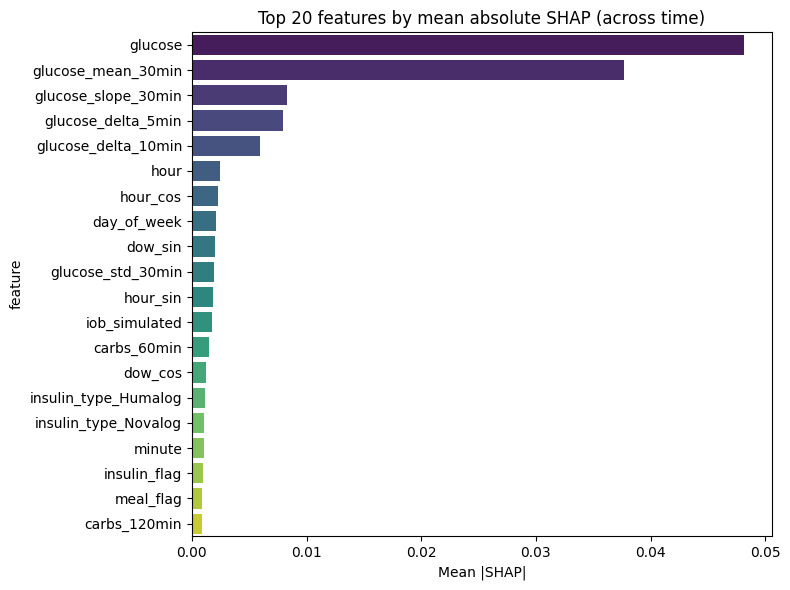

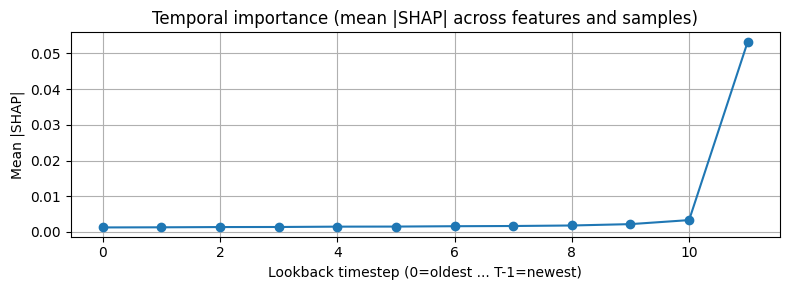

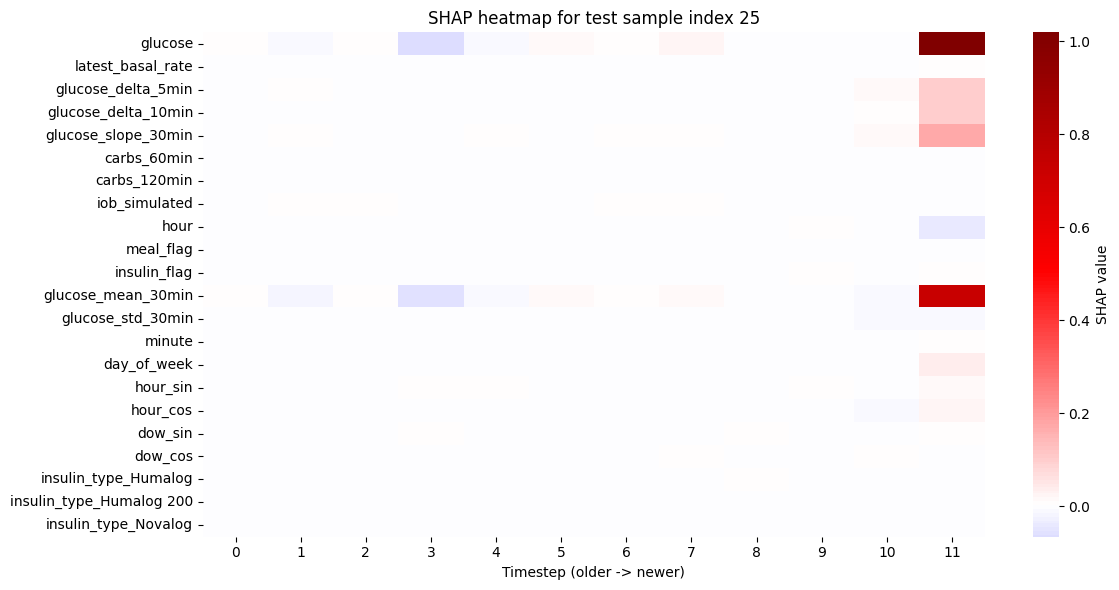

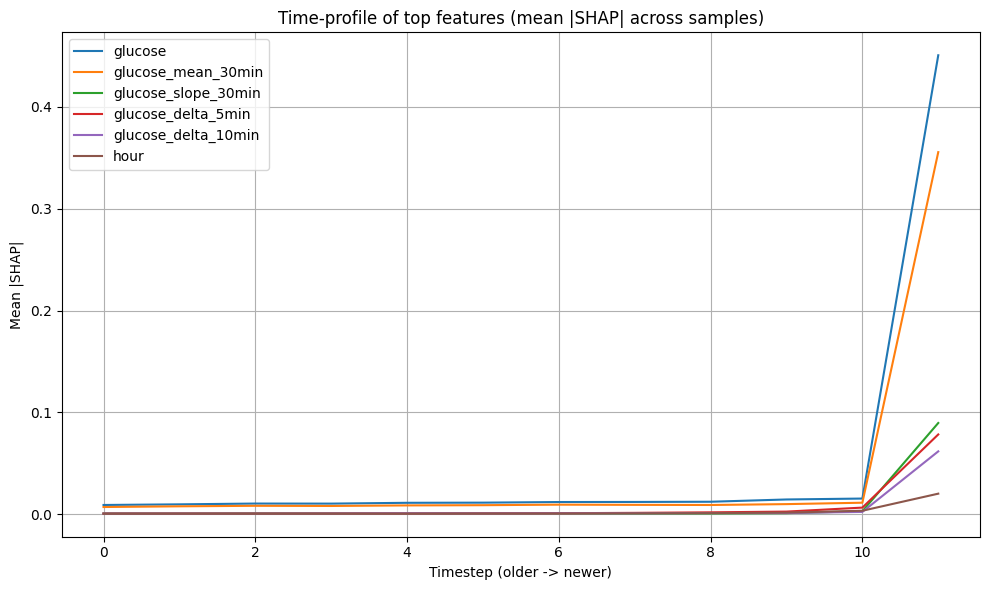

SHAP run complete. Results saved to shap_results


In [ ]:
# === SHAP for sequence LSTM (GradientExplainer) ===
# Requirements: shap, matplotlib, seaborn
# pip install shap matplotlib seaborn

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# reproducibility
np.random.seed(42)

# ----- Config -----
BACKGROUND_SAMPLES = 200      # background size for GradientExplainer (200 is a good default)
EXPLAIN_SAMPLES = 500         # number of test samples to explain (use smaller if memory limited)
SAVE_DIR = "shap_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ----- Sanity checks -----
assert 'model' in globals(), "model not found. Set variable 'model' to your trained Keras model."
assert X_test_seq.ndim == 3, "X_test_seq must be 3D (N, T, F)."
timesteps = X_test_seq.shape[1]
n_features = X_test_seq.shape[2]
# Ensure feature_names are available (assuming X is the original feature DataFrame before scaling/sequencing)
feature_names = X.columns.tolist() if 'X' in globals() else [f'Feature_{i}' for i in range(n_features)]
assert len(feature_names) == n_features, f"feature_names length ({len(feature_names)}) != n_features ({n_features})"

# ----- prepare background and explanation subset -----
# Use training data as background (or X_train_final if available)
if 'X_train_final' in globals() and X_train_final.shape[0] >= BACKGROUND_SAMPLES:
    X_bg_pool = X_train_final
elif 'X_train_seq' in globals() and X_train_seq.shape[0] >= BACKGROUND_SAMPLES:
     X_bg_pool = X_train_seq
else:
    # fall back to first portion of X_test_seq
    X_bg_pool = X_test_seq

bg_n = min(BACKGROUND_SAMPLES, X_bg_pool.shape[0])
background = X_bg_pool[np.random.choice(X_bg_pool.shape[0], size=bg_n, replace=False)]

m = min(EXPLAIN_SAMPLES, X_test_seq.shape[0])
X_explain = X_test_seq[:m]

print(f"Background samples: {background.shape}, Explain samples: {X_explain.shape}")

# ----- Build the model by calling it once with dummy data -----
# This is necessary for GradientExplainer if the model hasn't been trained yet.
# Use one sample from the background data to get the correct shape.
if not model.built:
    print("Building model by calling it once...")
    _ = model(background[:1])
    print("Model built.")


# ----- Create GradientExplainer -----
# GradientExplainer expects (model.input, model.output) tuple or model object.
# For Keras models, this works fine.
# explainer = shap.GradientExplainer((model.input, model.output), background) # Old way
explainer = shap.GradientExplainer(model, background) # New way using model object directly


# Compute SHAP values (this returns a list because explainer supports multi-output)
shap_values = explainer.shap_values(X_explain)
print("Raw SHAP values output type:", type(shap_values))
print("Raw SHAP values output shape (if list):", shap_values[0].shape if isinstance(shap_values, list) else "Not a list")

# Ensure shap_values is a numpy array with shape (m, T, F)
if isinstance(shap_values, list):
    # Assuming single output, take the first element
    shap_values = np.array(shap_values[0])
else:
    shap_values = np.array(shap_values)

# If the shape is (m, T, F, 1), squeeze the last dimension
if shap_values.ndim == 4 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)

# Explicitly reshape to (m, timesteps, n_features) if it's not already
if shap_values.shape != (m, timesteps, n_features):
    print(f"SHAP values have unexpected shape {shap_values.shape}. Attempting reshape to ({m}, {timesteps}, {n_features}).")
    # This reshape might fail if the number of elements doesn't match
    try:
        shap_values = shap_values.reshape(m, timesteps, n_features)
        print("Reshape successful.")
    except ValueError:
        print(f"Failed to reshape SHAP values from {shap_values.shape} to ({m}, {timesteps}, {n_features}). Check dimensions.")
        # Optionally, save the raw output and exit
        np.save(os.path.join(SAVE_DIR, "raw_shap_output.npy"), shap_values)
        raise # Re-raise the exception after printing info


print("Processed SHAP values shape:", shap_values.shape)  # Expected shape: (m, T, F)

# Save raw shap array (optional)
np.save(os.path.join(SAVE_DIR, "shap_values.npy"), shap_values)

# ----- Aggregate SHAP: feature-level global importance -----
# compute mean absolute SHAP across samples and timesteps -> importance per feature
# The original code was correct assuming shap_values is (m, T, F)
mean_abs_shap_feature = np.mean(np.mean(np.abs(shap_values), axis=0), axis=0)  # shape (F,)
feat_imp_df = pd.DataFrame({
    'feature': feature_names, # Use feature_names
    'mean_abs_shap': mean_abs_shap_feature
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

# Save feature importance
feat_imp_df.to_csv(os.path.join(SAVE_DIR, "shap_feature_importance.csv"), index=False)
print("Top features by mean |SHAP|:")
print(feat_imp_df.head(15))

# ----- Temporal importance: which timesteps matter most -----
# mean abs across features and samples -> vector length T
mean_abs_shap_timestep = np.mean(np.mean(np.abs(shap_values), axis=0), axis=1)  # (T,)
# If above indexing wrong, try: np.mean(np.mean(np.abs(shap_values), axis=0), axis=1)
# confirm shape:
print("Temporal importance shape (timesteps):", mean_abs_shap_timestep.shape)

# Plot top features bar chart
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_df.head(20), x='mean_abs_shap', y='feature', palette='viridis')
plt.title("Top 20 features by mean absolute SHAP (across time)")
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "shap_top20_features.png"), dpi=200)
plt.show()

# Plot temporal importance (older -> newer)
plt.figure(figsize=(8,3))
plt.plot(np.arange(timesteps), mean_abs_shap_timestep, marker='o')
plt.xlabel("Lookback timestep (0=oldest ... T-1=newest)")
plt.ylabel("Mean |SHAP|")
plt.title("Temporal importance (mean |SHAP| across features and samples)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "shap_temporal_importance.png"), dpi=200)
plt.show()

# ----- Per-sample SHAP heatmap for an example sample -----
# choose a representative sample index (0 <= idx < m)
example_idx = min(25, m-1)   # e.g., pick 25th explained sample
sv = shap_values[example_idx]   # shape (T, F)
# Plot heatmap: features on y-axis, timesteps on x-axis
plt.figure(figsize=(12,6))
sns.heatmap(sv.T, cmap='seismic', center=0, xticklabels=range(0, timesteps, max(1, timesteps//12)),
            yticklabels=feature_names, cbar_kws={'label': 'SHAP value'}) # Use feature_names
plt.xlabel("Timestep (older -> newer)")
plt.title(f"SHAP heatmap for test sample index {example_idx}")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, f"shap_heatmap_sample_{example_idx}.png"), dpi=200)
plt.show()

# ----- Per-feature time-profile (how the importance of a specific feature evolves across timesteps) -----
top_features = feat_imp_df['feature'].tolist()[:6]   # top 6 features
feature_idx_map = {f: i for i,f in enumerate(feature_names)} # Use feature_names

plt.figure(figsize=(10,6))
for f in top_features:
    idx = feature_idx_map[f]
    # mean abs shap for this feature across samples by timestep -> shape (T,)
    arr = np.mean(np.abs(shap_values[:, :, idx]), axis=0)
    plt.plot(np.arange(timesteps), arr, label=f)
plt.xlabel("Timestep (older -> newer)")
plt.ylabel("Mean |SHAP|")
plt.title("Time-profile of top features (mean |SHAP| across samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "shap_time_profiles_top_features.png"), dpi=200)
plt.show()

# ----- Save aggregated arrays for downstream use -----
np.save(os.path.join(SAVE_DIR, "mean_abs_shap_feature.npy"), mean_abs_shap_feature)
np.save(os.path.join(SAVE_DIR, "mean_abs_shap_timestep.npy"), mean_abs_shap_timestep)

print("SHAP run complete. Results saved to", SAVE_DIR)

Running MC dropout T = 300
MC preds shape: (300, 13831)
Point-prediction (MC mean) MAE: 16.292  RMSE: 24.146  R2: 0.841
Empirical coverages:
  50% interval coverage: 36.67%
  80% interval coverage: 61.96%
  90% interval coverage: 72.25%
  95% interval coverage: 78.80%


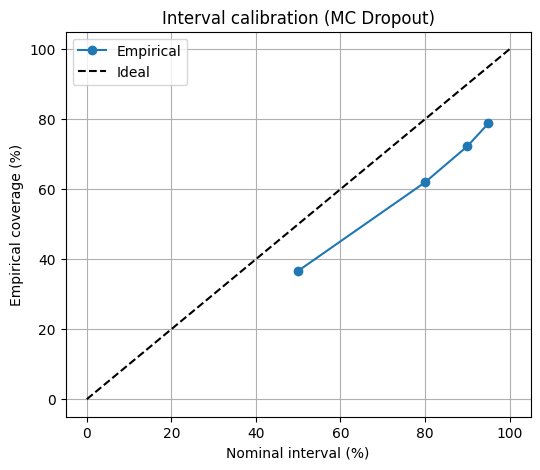

Average 95% interval width: 50.27 mg/dL
Top 10 indices with largest predictive std: [10623  4658  1331   393 11863  9316 11051   600  3732 11425]


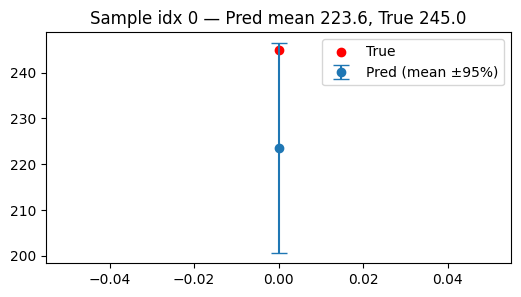

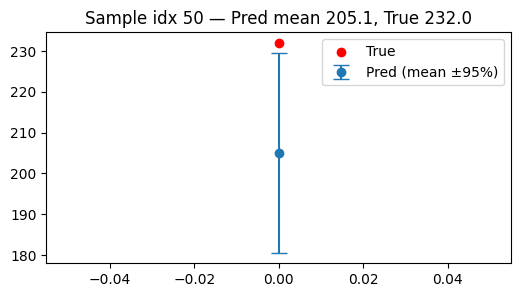

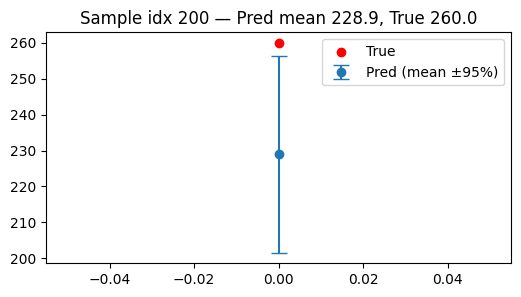

MC Dropout run complete.


In [ ]:
# === MC Dropout: predictive intervals, coverage, calibration ===
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ---------- Configuration ----------
MC_SAMPLES = 300     # number of stochastic forward passes (50-200 typical)
ALPHAS = [50, 80, 90, 95]   # percentiles for calibration plot
PLOT_N_EXAMPLES = 3  # how many example patients/time series to plot

# ---------- Helper: MC dropout predictions ----------
def mc_dropout_predict(model, X, T=100, batch_size=256):
    """
    Run T stochastic forward passes with dropout active.
    Returns: preds_array shape (T, N)
    """
    preds = []
    for i in range(T):
        # call model with training=True to enable Dropout at inference
        p = model(X, training=True).numpy().squeeze()
        preds.append(p)
    preds = np.stack(preds, axis=0)  # (T, N)
    return preds

# ---------- Run MC dropout on test set ----------
print("Running MC dropout T =", MC_SAMPLES)
preds_t = mc_dropout_predict(model, X_test_seq, T=MC_SAMPLES)
print("MC preds shape:", preds_t.shape)  # (T, N)

# Calculate unscaled true test values
y_test_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).squeeze()

# ---------- Aggregate: mean, std, intervals (scaled space) ----------
pred_mean_scaled = preds_t.mean(axis=0)      # (N,)
pred_std_scaled  = preds_t.std(axis=0)       # (N,)

# If you scaled y with scaler_y earlier, inverse-transform mean and intervals
# scaler_y expects shape (-1,1)
pred_mean_unscaled = scaler_y.inverse_transform(pred_mean_scaled.reshape(-1,1)).squeeze()
# For std, we approximate by scaling std with same scaler scale (std scaling)
# Compute scale factor from scaler_y
y_scale = scaler_y.scale_[0] if hasattr(scaler_y, "scale_") else np.std(y_train_true)
pred_std_unscaled = pred_std_scaled * y_scale

# 95% interval
lower_95 = pred_mean_unscaled - 1.96 * pred_std_unscaled
upper_95 = pred_mean_unscaled + 1.96 * pred_std_unscaled

# ---------- Basic metrics ----------
mae = mean_absolute_error(y_test_true, pred_mean_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_true, pred_mean_unscaled))
r2 = r2_score(y_test_true, pred_mean_unscaled)
print(f"Point-prediction (MC mean) MAE: {mae:.3f}  RMSE: {rmse:.3f}  R2: {r2:.3f}")

# ---------- Coverage calculation for chosen alphas ----------
def empirical_coverage(y_true, mean, std, alpha):
    """
    alpha in percent (e.g., 95) -> z for two-sided interval
    returns empirical coverage fraction
    """
    from math import sqrt
    import scipy.stats as st
    z = {50:0.674, 80:1.2816, 90:1.6449, 95:1.96}.get(alpha, st.norm.ppf(0.5+alpha/200.0))
    lower = mean - z * std
    upper = mean + z * std
    covered = (y_true >= lower) & (y_true <= upper)
    return covered.mean() * 100

print("Empirical coverages:")
for a in ALPHAS:
    cov = empirical_coverage(y_test_true, pred_mean_unscaled, pred_std_unscaled, a)
    print(f"  {a}% interval coverage: {cov:.2f}%")

# ---------- Calibration plot (nominal vs empirical) ----------
nominal = []
empirical = []
for a in ALPHAS:
    nominal.append(a)
    cov = empirical_coverage(y_test_true, pred_mean_unscaled, pred_std_unscaled, a)
    empirical.append(cov)

plt.figure(figsize=(6,5))
plt.plot(nominal, empirical, marker='o', label='Empirical')
plt.plot([0,100],[0,100],'k--', label='Ideal')
plt.xlabel('Nominal interval (%)')
plt.ylabel('Empirical coverage (%)')
plt.title('Interval calibration (MC Dropout)')
plt.legend()
plt.grid(True)
plt.show()

# ---------- Average interval width (for 95%) ----------
avg_width_95 = np.mean(upper_95 - lower_95)
print(f"Average 95% interval width: {avg_width_95:.2f} mg/dL")

# ---------- Where is uncertainty largest? (by event) ----------
# Example: compute mean std around post-meal samples if you have meal flags; else top-k uncertain samples
top_uncert_idx = np.argsort(-pred_std_unscaled)[:20]
print("Top 10 indices with largest predictive std:", top_uncert_idx[:10])

# ---------- Plot example time-series with intervals ----------
# We'll plot first PLOT_N_EXAMPLES sequences from X_test_seq as time series of predictions vs true.
N = X_test_seq.shape[0]
example_idxs = [0, 50, 200]  # choose examples (or use top_uncert_idx[:PLOT_N_EXAMPLES])
example_idxs = [i for i in example_idxs if i < N][:PLOT_N_EXAMPLES]

for idx in example_idxs:
    # For a sequence-level plotting, we need the time index mapping.
    # Here we assume each row is a single prediction (30-min ahead); to visualize over time for a subject
    # you'd gather consecutive predictions belonging to same subject and plot. For simplicity, plot single point.
    plt.figure(figsize=(6,3))
    plt.errorbar([0], [pred_mean_unscaled[idx]], yerr=[1.96*pred_std_unscaled[idx]], fmt='o', capsize=6, label='Pred (mean ±95%)')
    plt.scatter([0], [y_test_true[idx]], color='red', label='True')
    plt.title(f"Sample idx {idx} — Pred mean {pred_mean_unscaled[idx]:.1f}, True {y_test_true[idx]:.1f}")
    plt.legend()
    plt.show()

# ---------- More useful: per-subject time series with intervals (if you have subject ids) ----------
# If you have `subject_ids_test` aligned with X_test_seq, plot for a chosen subject:
if 'subject_ids_test' in globals():
    sid = subject_ids_test[0]  # choose first subject id or specific one
    idxs = np.where(subject_ids_test == sid)[0]
    if len(idxs) > 5:
        # sort by chronological order if you have timestamps
        pred_series = pred_mean_unscaled[idxs]
        lower_s = lower_95[idxs]
        upper_s = upper_95[idxs]
        true_series = y_test_true[idxs]
        plt.figure(figsize=(12,3))
        plt.plot(pred_series, label='Pred mean')
        plt.fill_between(np.arange(len(pred_series)), lower_s, upper_s, alpha=0.2, label='95% interval')
        plt.plot(true_series, label='True', alpha=0.8)
        plt.title(f"Subject {sid} predictions with 95% interval")
        plt.legend(); plt.show()

# ---------- Save arrays for downstream reports ----------
# np.save("mc_pred_mean_unscaled.npy", pred_mean_unscaled)
# np.save("mc_pred_std_unscaled.npy", pred_std_unscaled)
# np.save("mc_lower_95.npy", lower_95)
# np.save("mc_upper_95.npy", upper_95)

print("MC Dropout run complete.")

##MC DropOut

Running MC Dropout with T = 300


MC draws: 100%|██████████| 300/300 [1:19:49<00:00, 15.96s/it]

MC preds shape: (300, 13831)
Point-prediction (MC mean) MAE: 16.290  RMSE: 24.133  R2: 0.841

Empirical coverages (pre-calibration):
  50% interval coverage: 36.60%
  80% interval coverage: 62.03%
  90% interval coverage: 72.45%
  95% interval coverage: 79.00%


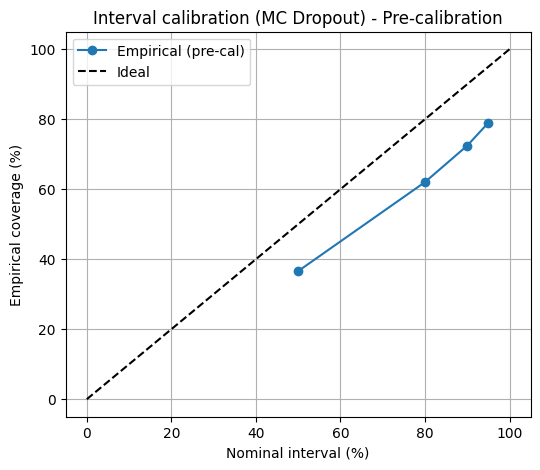


Average 95% interval width (pre-calibration): 50.29 (same units as target)

Spearman correlation (pred_std, |error|) = 0.201 (p=1.7e-126)
Top 10 indices with largest predictive std: [ 7397  1331  9074  2126 10623   487  3535  5544 12506 11051]


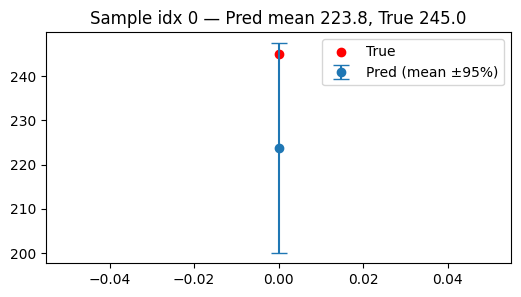

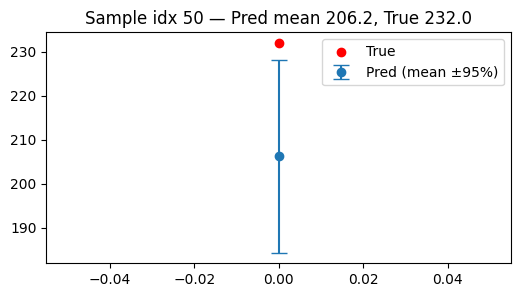

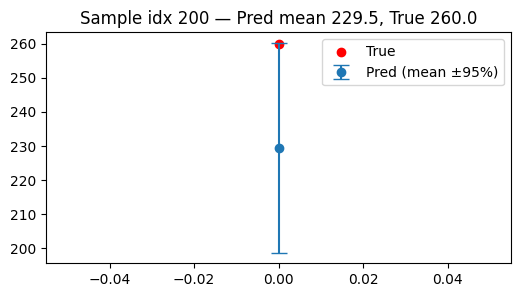

NameError: name 'has_val' is not defined

In [ ]:
# ===== Complete MC Dropout script (batched, calibration, diagnostics) =====
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import scipy.stats as st
import os
from tqdm import trange

# ----------------- CONFIG -----------------
MC_SAMPLES = 300       # number of stochastic forward passes (try 300, 500)
BATCH_SIZE = 128
ALPHAS = [50, 80, 90, 95]   # percentiles to evaluate coverage
PLOT_N_EXAMPLES = 3
SAVE_DIR = "./mc_dropout_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# ----------------- CHECK / PLACEHOLDERS -----------------
# The script expects the following variables to exist in the environment:
# - model : trained Keras model (with dropout layers; dropout active when model(..., training=True))
# - X_test_seq : numpy array shape (N_test, timesteps, n_features)
# - y_test_seq : numpy array shape (N_test,) OR (N_test,1) scaled values (before inverse_transform)
# - X_val_seq, y_val_seq : validation data (for calibration). If not available, calibration step will be skipped.
# - scaler_y : sklearn StandardScaler fitted on training targets (required for unscaling)
#
X_test = np.asarray(X_test_seq)
y_test_scaled = np.asarray(y_test_seq).reshape(-1)
if y_test_scaled.ndim != 1:
    y_test_scaled = y_test_scaled.squeeze()
# ----------------- Utility functions -----------------
def mc_dropout_predict_batched(model, X, T=300, batch_size=128):
    """
    Run T stochastic forward passes with dropout active (training=True).
    Returns preds array of shape (T, N)
    """
    N = X.shape[0]
    preds = np.zeros((T, N), dtype=np.float32)
    for t in trange(T, desc="MC draws"):
        out_chunks = []
        for i in range(0, N, batch_size):
            xb = X[i:i+batch_size]
            # ensure model call keeps dropout active
            p = model(xb, training=True).numpy().squeeze()
            out_chunks.append(p)
        preds[t] = np.concatenate(out_chunks, axis=0)
    return preds

def empirical_coverage_pct(y_true, mean, std, alpha_pct):
    """
    alpha_pct: e.g., 95
    returns coverage in percent
    """
    z_map = {50:0.674, 80:1.2816, 90:1.6449, 95:1.96}
    z = z_map.get(alpha_pct, st.norm.ppf(0.5 + alpha_pct/200.0))
    lower = mean - z * std
    upper = mean + z * std
    covered = (y_true >= lower) & (y_true <= upper)
    return covered.mean() * 100

def find_alpha_scale(y_val_true, mean_val, std_val, target_pct=95, grid=np.linspace(0.3, 5.0, 200)):
    """
    Find scalar alpha such that empirical coverage of (mean, alpha*std) on validation ~ target_pct.
    Returns best alpha (float).
    """
    best_a, best_err = 1.0, 1e9
    for a in grid:
        cov = empirical_coverage_pct(y_val_true, mean_val, a * std_val, target_pct)
        err = abs(cov - target_pct)
        if err < best_err:
            best_err = err
            best_a = a
    return best_a

# ----------------- Run MC Dropout predictions -----------------
print("Running MC Dropout with T =", MC_SAMPLES)
preds_t = mc_dropout_predict_batched(model, X_test, T=MC_SAMPLES, batch_size=BATCH_SIZE)  # shape (T, N)
print("MC preds shape:", preds_t.shape)

# ----------------- Unscale targets & preds (StandardScaler assumed) -----------------
if not hasattr(scaler_y, "scale_"):
    raise RuntimeError("scaler_y does not have attribute 'scale_'. This code assumes StandardScaler. Please supply StandardScaler-fitted scaler for y.")

y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).squeeze()
pred_mean_scaled = preds_t.mean(axis=0)
pred_std_scaled  = preds_t.std(axis=0)

pred_mean_unscaled = scaler_y.inverse_transform(pred_mean_scaled.reshape(-1,1)).squeeze()
y_scale = scaler_y.scale_[0]
pred_std_unscaled = pred_std_scaled * y_scale   # approximate std in original units

# Basic point metrics
mae = mean_absolute_error(y_test_true, pred_mean_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_true, pred_mean_unscaled))
r2 = r2_score(y_test_true, pred_mean_unscaled)
print(f"Point-prediction (MC mean) MAE: {mae:.3f}  RMSE: {rmse:.3f}  R2: {r2:.3f}")

# ----------------- Coverage (pre-calibration) -----------------
print("\nEmpirical coverages (pre-calibration):")
nominal = []
empirical = []
for a in ALPHAS:
    cov = empirical_coverage_pct(y_test_true, pred_mean_unscaled, pred_std_unscaled, a)
    print(f"  {a}% interval coverage: {cov:.2f}%")
    nominal.append(a); empirical.append(cov)

# calibration plot pre-calibration
plt.figure(figsize=(6,5))
plt.plot(nominal, empirical, marker='o', label='Empirical (pre-cal)')
plt.plot([0,100],[0,100],'k--', label='Ideal')
plt.xlabel('Nominal interval (%)'); plt.ylabel('Empirical coverage (%)')
plt.title('Interval calibration (MC Dropout) - Pre-calibration')
plt.legend(); plt.grid(True)
plt.show()

# ----------------- Average interval width (95%) pre-calibration -----------------
z95 = 1.96
lower_95 = pred_mean_unscaled - z95 * pred_std_unscaled
upper_95 = pred_mean_unscaled + z95 * pred_std_unscaled
avg_width_95 = np.mean(upper_95 - lower_95)
print(f"\nAverage 95% interval width (pre-calibration): {avg_width_95:.2f} (same units as target)")

# ----------------- Spearman correlation between std and absolute error -----------------
abs_err = np.abs(y_test_true - pred_mean_unscaled)
rho, pval = spearmanr(pred_std_unscaled, abs_err)
print(f"\nSpearman correlation (pred_std, |error|) = {rho:.3f} (p={pval:.3g})")

# ----------------- Find top uncertain samples -----------------
top_uncert_idx = np.argsort(-pred_std_unscaled)[:20]
print("Top 10 indices with largest predictive std:", top_uncert_idx[:10])

# ----------------- Plot some examples with error bars -----------------
N = X_test.shape[0]
example_idxs = [0, 50, 200]
example_idxs = [i for i in example_idxs if i < N][:PLOT_N_EXAMPLES]
for idx in example_idxs:
    plt.figure(figsize=(6,3))
    plt.errorbar([0], [pred_mean_unscaled[idx]], yerr=[z95 * pred_std_unscaled[idx]], fmt='o', capsize=6, label='Pred (mean ±95%)')
    plt.scatter([0], [y_test_true[idx]], color='red', label='True')
    plt.title(f"Sample idx {idx} — Pred mean {pred_mean_unscaled[idx]:.1f}, True {y_test_true[idx]:.1f}")
    plt.legend(); plt.show()

# ----------------- Per-subject series plot (if subject_ids_test available) -----------------
if 'subject_ids_test' in globals():
    sid = subject_ids_test[0]
    idxs = np.where(subject_ids_test == sid)[0]
    if len(idxs) > 5:
        pred_series = pred_mean_unscaled[idxs]
        lower_s = pred_series - z95 * pred_std_unscaled[idxs]
        upper_s = pred_series + z95 * pred_std_unscaled[idxs]
        true_series = scaler_y.inverse_transform(y_test_scaled[idxs].reshape(-1,1)).squeeze()
        plt.figure(figsize=(12,3))
        plt.plot(pred_series, label='Pred mean'); plt.fill_between(np.arange(len(pred_series)), lower_s, upper_s, alpha=0.2, label='95% interval')
        plt.plot(true_series, label='True', alpha=0.8)
        plt.title(f"Subject {sid} predictions with 95% interval"); plt.legend(); plt.show()

# ----------------- Calibration on validation (learn alpha) -----------------
if has_val:
    print("\nCalibrating sigma using validation set...")
    # run MC on validation set (batched)
    preds_val_t = mc_dropout_predict_batched(model, X_val, T=MC_SAMPLES, batch_size=BATCH_SIZE)
    pred_mean_val_scaled = preds_val_t.mean(axis=0)
    pred_std_val_scaled = preds_val_t.std(axis=0)
    pred_mean_val_unscaled = scaler_y.inverse_transform(pred_mean_val_scaled.reshape(-1,1)).squeeze()
    pred_std_val_unscaled = pred_std_val_scaled * y_scale
    y_val_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1,1)).squeeze()

    best_alpha = find_alpha_scale(y_val_true, pred_mean_val_unscaled, pred_std_val_unscaled, target_pct=95)
    print("Found calibration alpha on val:", best_alpha)

    # apply calibration to test std
    pred_std_unscaled_cal = pred_std_unscaled * best_alpha

    # Coverage pre/post
    cov_pre = empirical_coverage_pct(y_test_true, pred_mean_unscaled, pred_std_unscaled, 95)
    cov_post = empirical_coverage_pct(y_test_true, pred_mean_unscaled, pred_std_unscaled_cal, 95)
    print(f"95% coverage: pre-cal = {cov_pre:.2f}%, post-cal = {cov_post:.2f}%")

    # avg width post-cal
    lower_95_cal = pred_mean_unscaled - z95 * pred_std_unscaled_cal
    upper_95_cal = pred_mean_unscaled + z95 * pred_std_unscaled_cal
    avg_width_95_cal = np.mean(upper_95_cal - lower_95_cal)
    print(f"Average 95% interval width (post-calibration): {avg_width_95_cal:.2f}")

    # Calibration plot post-calibration
    empirical_post = []
    for a in ALPHAS:
        empirical_post.append(empirical_coverage_pct(y_test_true, pred_mean_unscaled, pred_std_unscaled_cal, a))

    plt.figure(figsize=(6,5))
    plt.plot(nominal, empirical, marker='o', label='Empirical (pre-cal)')
    plt.plot(nominal, empirical_post, marker='o', label='Empirical (post-cal)')
    plt.plot([0,100],[0,100],'k--', label='Ideal')
    plt.xlabel('Nominal interval (%)'); plt.ylabel('Empirical coverage (%)')
    plt.title('Interval calibration (MC Dropout): pre vs post calibration')
    plt.legend(); plt.grid(True); plt.show()
else:
    print("\nValidation set not available; skipping calibration step.")

# ----------------- Save arrays for downstream reports -----------------
np.save(os.path.join(SAVE_DIR, "mc_pred_mean_unscaled.npy"), pred_mean_unscaled)
np.save(os.path.join(SAVE_DIR, "mc_pred_std_unscaled.npy"), pred_std_unscaled)
np.save(os.path.join(SAVE_DIR, "mc_lower_95_pre.npy"), lower_95)
np.save(os.path.join(SAVE_DIR, "mc_upper_95_pre.npy"), upper_95)
if has_val:
    np.save(os.path.join(SAVE_DIR, "mc_pred_std_unscaled_cal.npy"), pred_std_unscaled_cal)
    np.save(os.path.join(SAVE_DIR, "mc_lower_95_post.npy"), lower_95_cal)
    np.save(os.path.join(SAVE_DIR, "mc_upper_95_post.npy"), upper_95_cal)

print("\nMC Dropout run complete. Outputs saved to:", SAVE_DIR)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_seq)

# Convert from scaled to original (if you scaled y)
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mae = np.mean(np.abs(y_test_seq - y_pred))
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 0.5856
RMSE: 0.7208
R² Score: 0.4791


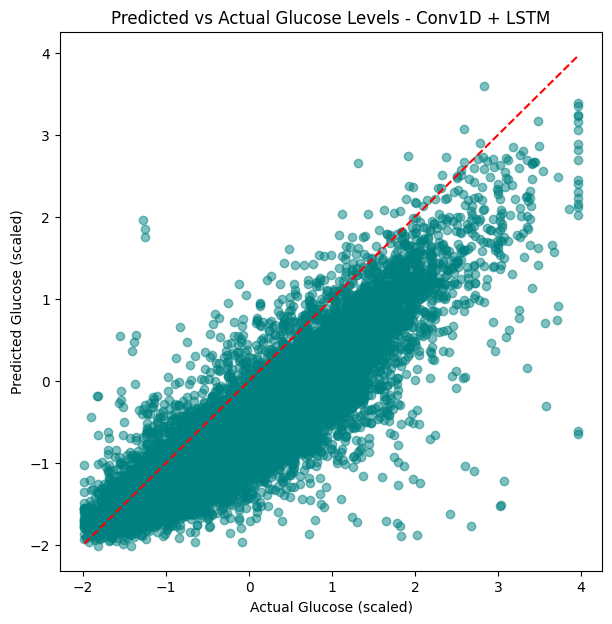

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test_seq, y_pred, alpha=0.5, color='teal')
plt.plot([y_test_seq.min(), y_test_seq.max()],
         [y_test_seq.min(), y_test_seq.max()],
         'r--')
plt.xlabel("Actual Glucose (scaled)")
plt.ylabel("Predicted Glucose (scaled)")
plt.title("Predicted vs Actual Glucose Levels - Conv1D + LSTM")
plt.show()


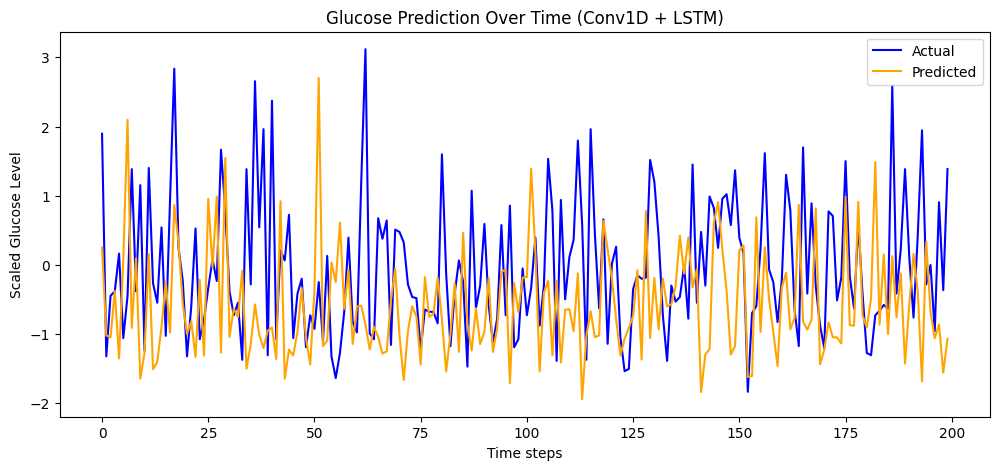

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='orange')
plt.xlabel("Time steps")
plt.ylabel("Scaled Glucose Level")
plt.title("Glucose Prediction Over Time (Conv1D + LSTM)")
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---------------- Assumptions ----------------
# You must already have:
#   X_train_seq.shape = (n_train, timesteps, n_features)
#   X_test_seq.shape  = (n_test,  timesteps, n_features)
#   y_train_scaled, y_test_scaled are 1D or shape (n,1) arrays (targets scaled)
# If y arrays are (n,), we reshape them below for fitting when needed.

# Example: if y_train_scaled is 1D, convert to shape (n,1)
if y_train_seq.ndim == 1:
    y_train_seq = y_train_seq.reshape(-1, 1)
if y_test_seq.ndim == 1:
    y_test_seq = y_test_seq.reshape(-1, 1)

# ---------------- ConvNeXt-inspired Block ---------------- #
def convnext_block(x, out_channels):
    """
    Simplified ConvNeXt-like block for 1D time-series:
      - depthwise conv (groups=input_channels)
      - LayerNorm
      - expand -> GELU -> project (pointwise convs)
      - residual add
    """
    input_channels = tf.keras.backend.int_shape(x)[-1]
    residual = x

    # depthwise-style conv: groups=input_channels
    x = layers.Conv1D(filters=input_channels, kernel_size=7, padding="same", groups=input_channels)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # pointwise MLP-style: expand and project
    x = layers.Conv1D(filters=4 * input_channels, kernel_size=1, padding="same", activation="gelu")(x)
    x = layers.Conv1D(filters=out_channels, kernel_size=1, padding="same")(x)

    # match residual channels if needed
    if input_channels != out_channels:
        residual = layers.Conv1D(filters=out_channels, kernel_size=1, padding="same")(residual)

    x = layers.Add()([x, residual])
    return x

# ---------------- Model Definition ---------------- #
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
inputs = layers.Input(shape=input_shape)

# Stem conv
x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Activation('gelu')(x)

# Stages: we keep this relatively lightweight to avoid overfitting
# We will downsample (stride=2) between stages to reduce temporal length moderately
dims = [64, 128]            # keep small to avoid over-parameterization
blocks_per_stage = [1, 1]   # shallow blocks per stage

for i, dim in enumerate(dims):
    # ConvNeXt blocks for this stage
    for _ in range(blocks_per_stage[i]):
        x = convnext_block(x, dim)

    # Transition / downsample between stages (except after last)
    if i < len(dims) - 1:
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv1D(filters=dims[i+1], kernel_size=1, strides=2, padding='same')(x)

# At this point x has shape (batch, timesteps_reduced, features)
# Directly feed into LSTM (it expects (batch, timesteps, features))
x = layers.LSTM(128, return_sequences=False, dropout=0.2)(x)
x = layers.Dropout(0.25)(x)

# Dense head
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs, outputs)

# Compile with lower lr (ConvNeXt can be sensitive) and gradient clipping
optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

model.summary()

# ---------------- Callbacks ---------------- #
es = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
mc = callbacks.ModelCheckpoint("best_convnext_lstm.keras", monitor='val_loss', save_best_only=True)

# ---------------- Training ---------------- #
history = model.fit(
    X_train_seq, y_train_scaled,
    validation_data=(X_test_seq, y_test_scaled),
    epochs=120,
    batch_size=64,
    callbacks=[es, mc],
    verbose=2
)

# ---------------- Evaluation ---------------- #
# Predict (scaled), then inverse-scale back to mg/dL
preds_scaled = model.predict(X_test_seq).squeeze()

# If you have y_scaler (StandardScaler) used before, inverse-transform to mg/dL:
# preds_unscaled = y_scaler.inverse_transform(preds_scaled.reshape(-1,1)).squeeze()
# y_test_unscaled = y_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).squeeze()

# If you don't need inverse scaling, compute metrics in scaled space:
mae_scaled = mean_absolute_error(y_test_seq, preds_scaled)
rmse_scaled = mean_squared_error(y_test_seq, preds_scaled, squared=False)
r2_scaled = r2_score(y_test_scaled, preds_scaled)

print("Metrics (scaled-space):")
print(f"MAE:  {mae_scaled:.4f}")
print(f"RMSE: {rmse_scaled:.4f}")
print(f"R2:   {r2_scaled:.4f}")

# If you have y_scaler, evaluate in mg/dL for clinical interpretation:
try:
    preds_unscaled = y_scaler.inverse_transform(preds_scaled.reshape(-1,1)).squeeze()
    y_test_unscaled = y_scaler.inverse_transform(y_test_seq.reshape(-1,1)).squeeze()

    mae_mgdl = mean_absolute_error(y_test_unscaled, preds_unscaled)
    rmse_mgdl = mean_squared_error(y_test_unscaled, preds_unscaled, squared=False)
    r2_mgdl = r2_score(y_test_unscaled, preds_unscaled)

    print("\nMetrics (mg/dL):")
    print(f"MAE (mg/dL):  {mae_mgdl:.3f}")
    print(f"RMSE (mg/dL): {rmse_mgdl:.3f}")
    print(f"R2 (mg/dL):   {r2_mgdl:.3f}")
except NameError:
    print("\nNote: y_scaler not found — metrics above are in scaled space. If you have a scaler, assign it to `y_scaler` to get mg/dL metrics.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │      3,136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 64)    │        128 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 12, 64)    │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 64)    │        512 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 256)   │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 64)    │     16,448 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 6, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 6, 128)    │      1,024 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 128)    │        256 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 6, 512)    │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 6, 128)    │     65,664 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 6, 128)    │          0 │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0] 

 Total params: 318,337 (1.21 MB)

 Trainable params: 318,337 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 55354
'y' sizes: 55365


In [ ]:
 from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_seq)

# Convert from scaled to original (if you scaled y)
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mae = np.mean(np.abs(y_test_seq - y_pred))
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
MAE: 0.8013
RMSE: 1.0068
R² Score: -0.0160
